Table of contents
1. [Imports](#Imports)
2. [Display settings](#Display_settings)
3. [Global functions](#Global_functions)
4. [Data import](#Data_import)
5. [Data processing](#Data_processing)

...5.1 [Reshaping datasets](#Reshaping_datasets)

...5.2 [Merging datasets](#Merging_datasets)

6. [Data analysis](#Data_Analysis)(main section)

### Imports

In [11]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import geopy
from geopy.distance import geodesic
from geopy import distance
from geopy.geocoders import Nominatim
import time
import string
from sklearn import preprocessing
%matplotlib inline

<a id='Display_settings'></a>
### Display settings

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 40)
sns.set(rc = {'figure.figsize':(15,8)})

<a id='Global_functions'></a>
### Global functions

In [13]:
def countplot(vc: pd.Series, dropna=True):
    if not dropna:
        vc = vc.fillna('missing')
        num_values = vc.shape[0]
    else:
        num_values = vc.count()

    graph = sns.countplot(vc)
    for p in graph.patches:
        graph.text(p.get_x() + p.get_width()*0.1, p.get_height() + p.get_height()/100, f'{p.get_height()}\n{round(p.get_height()/num_values,4)}')
    # graph.show()

def perc_counts(series: pd.Series, dropna=True) -> pd.DataFrame:
    if not dropna:
        series.fillna('missing', inplace=True)
    vc = series.value_counts()
    value_sum = sum(vc)
    perc = []
    for i in vc:
        perc.append(round(i/value_sum, 4) * 100)
    return pd.DataFrame(np.transpose([vc.values, perc]), columns=['count', 'percentage'], index=vc.index)

def clean_str(string: str):
    """
    Purpose: non-alphanumerical characters to "_" + lowercase
    """
    ok = re.compile("\W")
    for s in string:
        if bool(ok.match(s)):
            string = string.replace(s, '_')
    return string.lower()

def get_int_list(x: str) -> list:
    """
    Purpose: creating list of ints from ':' separated date-string (e.g. "14:12:13")
    """
    return list(map(int, x.split(':')))

def preprocess_columns(df: pd.DataFrame, cols_needed: list = None) -> pd.DataFrame:
    """
    Purpose: get rid off test accounts + unifying column names + turning duration of webinars into floats
    """
    if not cols_needed:
        cols_needed = df.columns

    # c = ''
    # for C in df:
    #     c = C.lower()
    #     if 'test' in c and 'account' in c:
    #         df = df[df[C]!=1]
    #         break
    #
    # if c == '':
    #     print('\"Test Account\" column is missing!')

    df = df[cols_needed]
    df.columns = list(map(clean_str, df.columns))
    if 'webinar_duration' in df.columns:
        df['webinar_duration'] = df['webinar_duration'].apply(lambda x: get_int_list(x)[0]*60 + get_int_list(x)[1] if isinstance(x, str) else x)
    return df

def convert_date(x):
    mDt = dt.datetime(1899, 12, 30)
    dlt = mDt + dt.timedelta(days=x)
    return dlt.strftime("%Y-%m-%d")

def get_dtypes(df: pd.DataFrame) -> dict:
    return {k: str(v) for k,v in df.convert_dtypes().dtypes.to_dict().items()}

<a id='Data_import'></a>
### Data import

In [4]:
# F webinars updated -> Basavaraj 12.10
filepath = 'data/F_Webinars_updated.csv'
f_web = preprocess_columns(pd.read_csv(filepath, low_memory=False)).drop_duplicates()
f_web = f_web.convert_dtypes()

# consider doing this during first run -> reduce memory usage
# f_web.to_csv(filepath, index=False)

In [5]:
# D webinar updated -> Basavaraj 12.10
filepath = 'data/D_Webinar_updated.csv'
d_web = preprocess_columns(pd.read_csv(filepath)).drop_duplicates()
d_web = d_web.convert_dtypes()

# consider doing this during first run -> reduce memory usage
# d_web.to_csv(filepath, index=False)

In [6]:
# D account all updated -> Basavaraj 13.10
filepath = 'data/d_account_all_updated.csv'
d_acc = preprocess_columns(pd.read_csv(filepath, low_memory=False)).drop_duplicates()
d_acc = d_acc.convert_dtypes()

# consider doing this during first run -> reduce memory usage
# d_acc.to_csv(filepath, index=False)

In [7]:
# Previously merged train dataset: merged from previous versions of F_Webinars (Basavaraj 16.08), D_Webinar (Basavaraj 16.08), D_Account_all (Basavaraj 12.10)
filepath = 'data/full_train_data_13.10.22.csv'
old_fd_dacc = preprocess_columns(pd.read_csv(filepath, low_memory=False)).drop_duplicates()
old_fd_dacc = old_fd_dacc.convert_dtypes()

# consider doing this during first run -> reduce memory usage
# old_fd_dacc.to_csv(filepath, index=False)

The reason why we also take the old training data is that we already preprocessed account and webinar coordinates there. But also the previous matching could be usefull for us.

In [37]:
dfs = {'f_web': f_web, 'd_web': d_web, 'd_acc': d_acc, 'fd_dacc_old': old_fd_dacc}

<a id='Data_processing'></a>
### Data processing

In [11]:
# Get shapes and infos
for name, df in dfs.items():
    print('\n')
    print(name + ' shape : ', df.shape)
    print(name + ' info : ', df.info())



f_web shape :  (153398, 38)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 153398 entries, 0 to 153397
Data columns (total 38 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   _account_key                153127 non-null  string 
 1   account_id                  153127 non-null  string 
 2   account_key_original        153398 non-null  string 
 3   account_id_na               153398 non-null  boolean
 4   _webinar_key                153398 non-null  Int64  
 5   _calendar_key               153398 non-null  Int64  
 6   _product_key                0 non-null       Int64  
 7   _segment_key                153398 non-null  string 
 8   _country_key                153398 non-null  string 
 9   _channel_key                153398 non-null  string 
 10  _campaign_key               9803 non-null    string 
 11  account_cnt                 153398 non-null  string 
 12  webinar_participants_cnt    153398 non-nul

<AxesSubplot:>

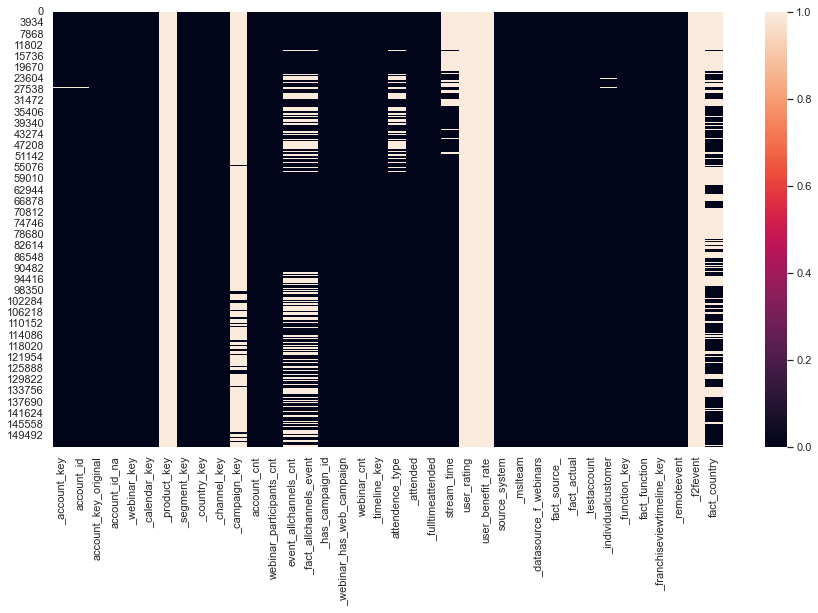

In [12]:
# Missing distribution f_web
sns.heatmap(f_web.isnull())

In [13]:
# d_web has no missing values

<AxesSubplot:>

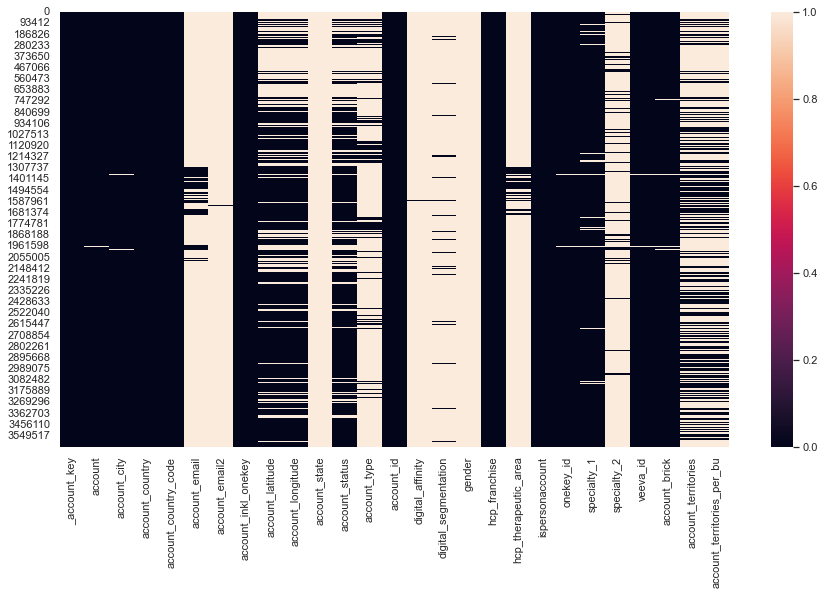

In [14]:
# Missing distribution d_acc
sns.heatmap(d_acc.isnull())

C:\Users\M302242\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


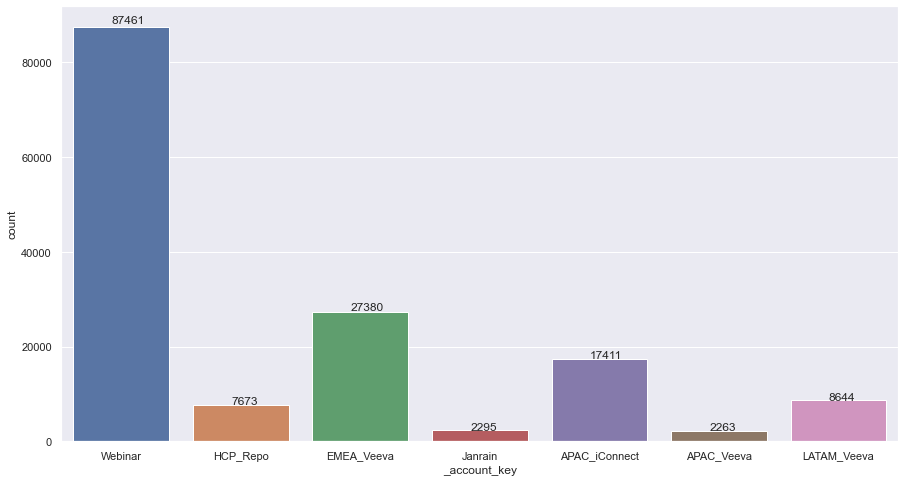

In [15]:
# account key distribution
countplot(f_web['_account_key'])

<a id='Reshaping_datasets'></a>
#### Reshaping datasets for our needs

In [8]:
# drop test accounts
f_web = f_web[f_web['_testaccount'] != 1]

In [10]:
# d_acc has two e-mails per HCP. We going to append a 'account email2' column to 'account email' and drop it, so we have only one consistent e-mail column. Later we going to merge HCPs from fd_web using 'account email' and 'account_id'.
print('# account email: ', d_acc['account_email'].count())

email2 = d_acc[d_acc['account_email2'].notnull()]
email2.drop(columns=['account_email'], inplace=True)
email2.rename(columns={'account_email2': 'account_email'}, inplace=True)
d_acc = d_acc.append(email2)
d_acc.drop(columns=['account_email2'], inplace=True)

# small report
print('# account email2: ', email2.shape[0])
print('# entries in \"account_email\": ', d_acc['account_email'].count())
print('# unique entries in \"account_email\": ',d_acc['account_email'].nunique())

# Free memory
email2 = None

# account email:  320912


C:\Users\M302242\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\M302242\Anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


# account email2:  8153
# entries in "account_email":  329065
# unique entries in "account_email":  113776


In [11]:
# looks like "account_id" and "_account_key" are the same
all(d_acc['account_id'] == d_acc['_account_key'])

True

In [12]:
# recreate "account_id" with its ids, leaving keys at "_account_key"
d_acc['account_id'] = d_acc['account_id'].apply(lambda x: x.split('|')[1] if isinstance(x, str) else x)

<a id='Merging_datasets'></a>
#### Merging datasets together

In [13]:
fd_web = f_web.merge(d_web, on='_webinar_key', how='inner')
fd_dacc = d_acc.merge(fd_web, on='account_id', suffixes=['', '_fdweb'] ,how='left')
fd_dacc2 = d_acc.merge(fd_web, left_on='account_email', right_on='account_key_original', suffixes=['', '_fdweb'], how='left')

fd_dacc = fd_dacc.append(fd_dacc2)
fd_dacc.drop_duplicates(subset=['account_id', '_webinar_key'], inplace=True)

# small report
print('shape before merge: ', d_acc.shape)
print('shape after merge: ', fd_dacc.shape)
print('# new rows: ', fd_dacc.shape[0] - d_acc.shape[0])

# Free memory
f_web = None
d_web = None
d_acc = None
fd_web = None
fd_dacc2 = None

shape before merge:  (3650998, 26)
shape after merge:  (3201277, 69)
# new rows:  -449721


Put old and new matching together

In [42]:
# look for the difference in features
print('Shared features: ', set(fd_dacc.columns).intersection(set(old_fd_dacc)))
print('\n')
print('Leftovers fd_dacc: ', set(fd_dacc.columns).difference(set(old_fd_dacc)))
print('\n')
print('Leftovers old_fd_dacc: ', set(old_fd_dacc.columns).difference(set(fd_dacc)))

Shared features:  {'specialty_1', 'attendence_type', 'account_key_original', 'stream_time', 'account_latitude', 'digital_segmentation', 'account_id', '_segment_key', 'webinar_duration', 'webinar_platform', '_webinar_key', '_webinar_has_web_campaign', 'hcp_therapeutic_area', '_attended', '_fulltimeattended', '_function_key', 'hcp_franchise', 'specialty_2', 'account_longitude'}


Leftovers fd_dacc:  {'account_city', '_has_campaign_id', 'user_rating', '_f2fevent', 'account_status', 'webinar_fileextension', '_fact_allchannels_event', 'account_email', 'webinar_participants_cnt', 'event_allchannels_cnt', 'fact_source_', 'user_benefit_rate', 'account_id_fdweb', 'fact_country', 'account_country_code', '_testaccount', '_account_key', '_timeline_key', '_channel_key', 'webinar_cnt', '_mslteam', 'account_state', 'account_type', '_individualcustomer', 'account_id_na', 'webinar_filename', '_product_key', 'account_cnt', 'account_inkl_onekey', '_account_key_fdweb', 'webinar_name', '_fact_actual', 'isp

In [20]:
fd_dacc.to_csv('new_fd_dacc.csv', index=False)

In [63]:
print('fd_dacc size: ', fd_dacc.shape)
print('old_fd_dacc size: ', old_fd_dacc.shape)
fd_dacc = fd_dacc.merge(old_fd_dacc[['account_id', 'date', 'webinar_latitude', 'webinar_longitude']], left_on='account_id', right_on='account_id', suffixes=['', '_old'], how='left')
fd_dacc.drop_duplicates(subset=['_webinar_key', 'account_id'], inplace=True)
print('New fd_dacc size: ', fd_dacc.shape)

# Free memory
# old_fd_dacc = None

fd_dacc size:  (3201277, 69)
old_fd_dacc size:  (1793648, 24)
New fd_dacc size:  (3201277, 72)


In [64]:
# lets take a look at the new dataset
fd_dacc[fd_dacc['_webinar_key'].notnull()].sample(50)

,_account_key,account,account_city,account_country,account_country_code,account_email,account_inkl_onekey,account_latitude,account_longitude,account_state,account_status,account_type,account_id,digital_affinity,digital_segmentation,gender,hcp_franchise,hcp_therapeutic_area,ispersonaccount,onekey_id,specialty_1,specialty_2,veeva_id,account_brick,account_territories,account_territories_per_bu,_account_key_fdweb,account_key_original,account_id_na,_webinar_key,_calendar_key,_product_key,_segment_key,_country_key,_channel_key,_campaign_key,account_cnt,webinar_participants_cnt,event_allchannels_cnt,_fact_allchannels_event,_has_campaign_id,_webinar_has_web_campaign,webinar_cnt,_timeline_key,attendence_type,_attended,_fulltimeattended,stream_time,user_rating,user_benefit_rate,source_system,_mslteam,_datasource_f_webinars,fact_source_,_fact_actual,_testaccount,_individualcustomer,_function_key,fact_function,_franchiseviewtimeline_key,_remoteevent,_f2fevent,fact_country,webinar_fileextension,webinar_filename,webinar_duration,webinar_name,webinar_platform,account_id_fdweb,date,webinar_latitude,webinar_longitude
1443824,EMEA_Veeva|0012o00002XpUnKAAV,ESTELLE PROST,LA ROCHE SUR YON CEDEX,France,FR,e.s.telle@hotmail.fr,ESTELLE PROST - WFRM00085209,46.658606,-1.41416,<NA>,Valid,<NA>,0012o00002XpUnKAAV,<NA>,<NA>,<NA>,Fertility,Fertility - General,True,WFRM00085209,Gynaecology,Obstetrics,0012o00002XpUnKAAV,UG2.WFR.85LRO,T8-FR-FE0101;T8-FR-FE0203;T8-FR-MGFR...,T8-FR-FE0101;T8-FR-FE0203;T8-FR-RMR-...,EMEA_Veeva,e.s.telle@hotmail.fr,False,265,44327,<NA>,Business Unit|Fertility,FR,Webinar,<NA>,EMEA_Veeva|0012o00002XpUnKAAV,80347,<NA>,<NA>,0,1,80181,Webinar|80181,<NA>,0,0,0.0,<NA>,<NA>,Webinar Excel,1,1,F_Webinars,1,0,1,Medical,Medical,WebinarMedical44327|44327|Webinar|FR...,1,<NA>,France,csv,5653004677.csv,120,conference-infertilite-masculine,Adobe Connect,<NA>,2021-05-11,46.603354,1.888334
1454471,EMEA_Veeva|0012o00002XLNPLAA5,Eiad Ismail AboGayab,Olaya,Saudi Arabia,SA,eyad.jayab@drsulaimanalhabb.com,Eiad Ismail AboGayab - WSAM00002929,24.70249,46.685282,<NA>,Valid,<NA>,0012o00002XLNPLAA5,<NA>,Not Segmented,<NA>,CM&E,GM&E - General,True,WSAM00002929,General Practice,<NA>,0012o00002XLNPLAA5,UG1.WSA.01,T8 - KSA - Cardio/Thyroid RUH 2;T8 -...,T8 - KSA - Cardio/Thyroid RUH 2;T8 -...,EMEA_Veeva,eyad.jayab@drsulaimanalhabb.com,False,86,43940,<NA>,Business Unit|Fertility,AU,Webinar,<NA>,EMEA_Veeva|0012o00002XLNPLAA5,43747,<NA>,<NA>,0,1,43341,Webinar|43341,<NA>,0,0,0.0,<NA>,<NA>,Webinar Excel,1,1,F_Webinars,1,0,1,Medical,Medical,WebinarMedical43940|43940|Webinar|AU...,1,<NA>,Australia,csv,4543030015.csv,180,Diabetes in Ramadan,Adobe Connect,<NA>,2020-04-12,-24.776109,134.755
1546448,Webinar|THALISWC@GMAIL.COM,Thalis Wollinger Cherobin,<NA>,Brazil,BR,thaliswc@gmail.com,Thalis Wollinger Cherobin -,<NA>,<NA>,<NA>,<NA>,<NA>,THALISWC@GMAIL.COM,<NA>,<NA>,<NA>,Multi-Franchise,<NA>,True,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Webinar,thaliswc@gmail.com,True,538,44614,<NA>,Business Unit|Fertility,BR,Webinar,<NA>,Webinar|THALISWC@GMAIL.COM,106942,F_Webinar|106942,1,0,1,106860,Webinar|106860,On-demand,1,0,93.15,<NA>,<NA>,Webinar Excel,1,1,F_Webinars,1,0,1,Medical,Medical,WebinarMedical44614|44614|Webinar|BR...,1,<NA>,Brazil,csv,647374.csv,120,Do treinamento ao monitoramento de k...,Intrado,<NA>,2022-02-22,-10.333333,-53.2
1571740,Webinar|ymis7of9@i.softbank.jp,石川 由美,<NA>,France,FR,ymis7of9@i.softbank.jp,石川 由美 -,<NA>,<NA>,<NA>,<NA>,<NA>,ymis7of9@i.softbank.jp,<NA>,<NA>,<NA>,Multi-Franchise,<NA>,True,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Webinar,ymis7of9@i.softbank.jp,True,218,44164,<NA>,Business Unit|Oncology,FR,Webinar,<NA>,Webinar|ymis7of9@i.softbank.jp,73807,F_Webinar|73807,1,0,1,73719,Webinar|73719,Live,1,1,145.63,<NA>,<NA>,Webinar Excel,1,1,F_Webinars,1,0,1,Medical,Medical,WebinarMedical44164|44164|Webinar|FR...,1,<NA>,France,csv,5039791539.csv,180,メルクバイオファーマ・オリジオ・ジャパンジョイントセミナー,Adobe Connect,<NA>,2020-09-06,46.603354,1.888334
1384589,EMEA_Veeva|0012o00002zzDTTAA2,Malika

In [65]:
fd_dacc = fd_dacc.convert_dtypes()
fd_dacc.to_csv('fd_dacc_full.csv', index=False)

<a id='Data_Analysis'></a>
### Data Analysis

In [10]:
fd_dacc = pd.read_csv('data/fd_dacc_full.csv', low_memory=False)

In [4]:
fd_dacc['account_country'].value_counts(dropna=False)

Germany         1117072
France           978011
Brazil           927609
Algeria           95219
Saudi Arabia      83366
Name: account_country, dtype: int64

In [5]:
fd_dacc[fd_dacc['account_territories'].notnull()]['account_country'].value_counts(dropna=False)

France          807828
Germany         271549
Algeria          46472
Saudi Arabia      7623
Name: account_country, dtype: int64

C:\Users\M302242\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


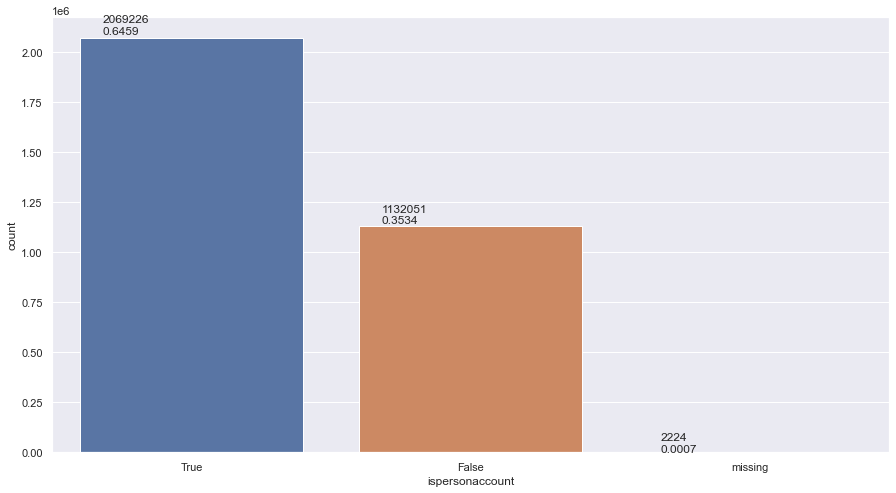

In [5]:
countplot(fd_dacc['ispersonaccount'], dropna=False)

In [9]:
matched = fd_dacc[fd_dacc['_webinar_key'].notnull()]
fd_dacc_ter = fd_dacc[fd_dacc['account_territories'].notnull()]
matched_ter = fd_dacc_ter[fd_dacc_ter['_webinar_key'].notnull()]
unmatched_ter = fd_dacc_ter[fd_dacc_ter['_webinar_key'].isnull()]

# complete filtering after adjusting on 25.10
# there's also a missing data in the column "ispersonaccount", so to filter just on true wouldn't be enough (graph above)
unmatched_ter = unmatched_ter[unmatched_ter['ispersonaccount'] != False]
fd_dacc_ter = pd.concat([matched_ter, unmatched_ter])

# free space
del unmatched_ter


In [10]:
fd_dacc_ter.shape

(759330, 72)

In [11]:
# how many entries have we matched? how many HCPs are unique? how many of them have a territory assigned?
print('Shape of the full set: ', fd_dacc.shape)
print('# Unique HCPs in the full set: ', fd_dacc.drop_duplicates('account_id').shape[0])
print('# Unique HCPs in the fd_dacc_ter set: ', fd_dacc_ter.drop_duplicates('account_id').shape[0])
print('# Matched entries: ', matched.shape[0])
print('# Unique matched HCPs: ', matched['_account_key'].nunique())
print('# Matched entries with territory assigned: ', matched_ter.shape[0])
print('# Unique matched HCPs with territory assigned: ', matched_ter.drop_duplicates('_account_key').shape[0])

Shape of the full set:  (3201277, 72)
# Unique HCPs in the full set:  3179998
# Unique HCPs in the fd_dacc_ter set:  752075
# Matched entries:  31597
# Unique matched HCPs:  11734
# Matched entries with territory assigned:  10457
# Unique matched HCPs with territory assigned:  3737


In [9]:
# get duplicated columns and their pos
uniq = set(fd_dacc.columns)
dups = {k: v for k,v in {x: i if x not in uniq else uniq.remove(x) for i, x in enumerate(fd_dacc.columns)}.items() if v is not None}
dups

{}

#### Going through columns and looking for usefull insides

Columns of interest of the d_acc side: account_state, account_type, account_status, digital_affinity, digital_segmentation, gender, hcp_franchise, hcp_therapeutic_area, ispersonaccount, specialty_1 and _2, account_territories and _per_bu

Columns of interest of the fd_web side: _account_key_fdweb, account_id_na, _webinar_key, _calendar_key, _product_key, _segment_key, _country_key, _campaign_key, _has_campaign_id, _webinar_has_web_campaign, attendence_type, _attended, _full_time_attended, user_rating, user_benefit_rate, _mslteam, _fact_actual, _testaccount, _individualcustomer, _function_key, fact_function, _remoteevent, _f2fevent, fact_country, webinar_duration, webinar_name, webinar_platform, date, webinar_registered

<AxesSubplot:>

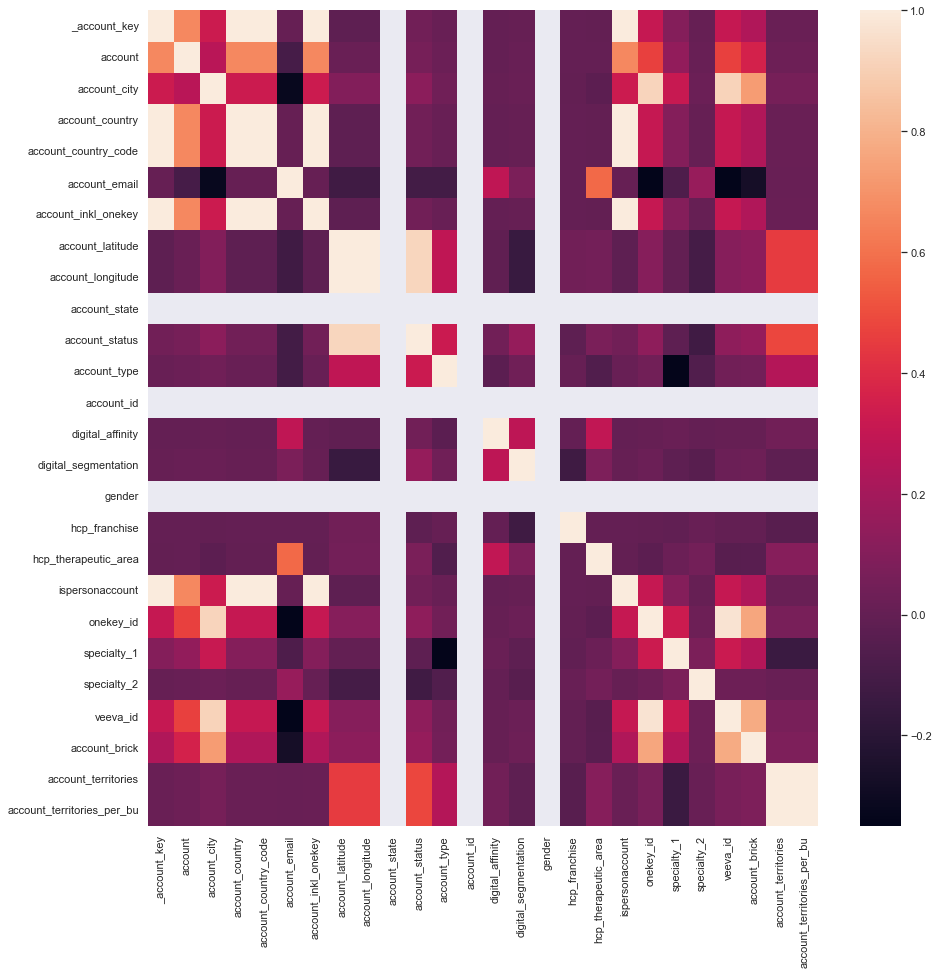

In [24]:
sns.set(rc = {'figure.figsize':(15,15)})
# correlation matrix of present/absent values on the d_acc side
sns.heatmap(fd_dacc[fd_dacc.columns[:26]].isnull().corr())

<AxesSubplot:>

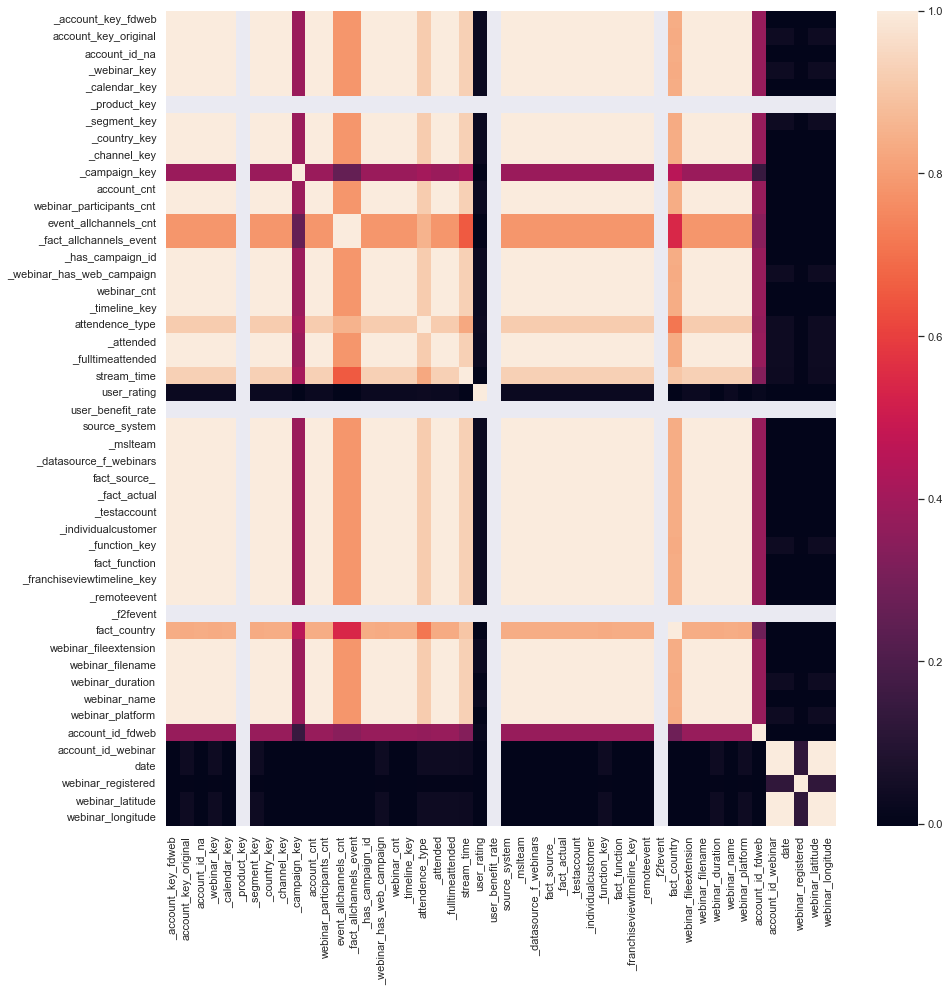

In [25]:
# correlation matrix of present/absent values on the fd_web side
sns.heatmap(fd_dacc[fd_dacc.columns[26:]].isnull().corr())

In [13]:
# chose the columns that we wouldn't take into the next part -> Deep Preprocessing
# we already see which columns we won't need for modelling
cols_to_drop = ['account_id', 'gender', '_product_key', 'user_benefit_rate', '_f2fevent']

In [70]:
sns.set(rc = {'figure.figsize':(8,6)})

##### account_state

In [28]:
fd_dacc['account_state'].unique()

array([nan])

=> account_state is empty and can be dropped

In [14]:
cols_to_drop.append('account_state')

##### account_type

In [9]:
# how many types are there in the full set
fd_dacc['account_type'].nunique()

241

In [32]:
# what are the different types that we could match
matched['account_type'].unique()

array([nan, 'Medical Analyses Laboratory', 'General Hospital', 'Practice',
       'Government Hospital', 'Association of Health Doctor'],
      dtype=object)

In [16]:
# Example
matched[matched['account_type'] == 'Medical Analyses Laboratory']
# Observation: it's not a person, still we could get a match

,_account_key,account,account_city,account_country,account_country_code,account_email,account_inkl_onekey,account_latitude,account_longitude,account_state,account_status,account_type,account_id,digital_affinity,digital_segmentation,gender,hcp_franchise,hcp_therapeutic_area,ispersonaccount,onekey_id,specialty_1,specialty_2,veeva_id,account_brick,account_territories,account_territories_per_bu,_account_key_fdweb,account_key_original,account_id_na,_webinar_key,_calendar_key,_product_key,_segment_key,_country_key,_channel_key,_campaign_key,account_cnt,webinar_participants_cnt,event_allchannels_cnt,_fact_allchannels_event,_has_campaign_id,_webinar_has_web_campaign,webinar_cnt,_timeline_key,attendence_type,_attended,_fulltimeattended,stream_time,user_rating,user_benefit_rate,source_system,_mslteam,_datasource_f_webinars,fact_source_,_fact_actual,_testaccount,_individualcustomer,_function_key,fact_function,_franchiseviewtimeline_key,_remoteevent,_f2fevent,fact_country,webinar_fileextension,webinar_filename,webinar_duration,webinar_name,webinar_platform,account_id_fdweb,account_id_webinar,date,webinar_registered,webinar_latitude,webinar_longitude
1392424,EMEA_Veeva|0012o00002XoYKkAAN,LAM PLANOISE,BESANCON,France,FR,NaN,LAM PLANOISE - WFRH01958610,47.215095,5.978514,NaN,Valid,Medical Analyses Laboratory,0012o00002XoYKkAAN,NaN,NaN,NaN,Oncology,NaN,False,WFRH01958610,Laboratory - Medical Analysis,Fertility/Reproductive,0012o00002XoYKkAAN,UG2.WFR.25MIS,T8-FR-MGFR,T8-FR-MGFR,EMEA_Veeva,philippe.dupont@cbm25.fr,False,265.0,44327.0,NaN,Business Unit|Fertility,FR,Webinar,NaN,EMEA_Veeva|0012o00002XoYKkAAN,80229.0,NaN,NaN,0.0,1.0,80181.0,Webinar|80181,NaN,0.0,0.0,0.0,NaN,NaN,Webinar Excel,1.0,1.0,F_Webinars,1.0,0.0,NaN,Medical,Medical,WebinarMedical44327|44327|Webinar|FR...,1.0,NaN,France,csv,5653004677.csv,120.0,conference-infertilite-masculine,Adobe Connect,NaN,NaN,NaN,NaN,NaN,NaN


=> Even if account isn't a person, it could be useful for the full set. But if we take into account only persons, like we do for "fd_acc_ter", it doen't make much sense...

In [11]:
for t in fd_dacc.groupby(['account_type']):
    print(f'Type: {t[0]} --> # isPerson {t[1][t[1]["ispersonaccount"] == 1].shape[0]} --> # notPerson {t[1][t[1]["ispersonaccount"] != 1].shape[0]}')

Type: AFE --> # isPerson 0 --> # notPerson 2
Type: AGB --> # isPerson 0 --> # notPerson 1
Type: ARH --> # isPerson 0 --> # notPerson 29
Type: Account Pharmacy --> # isPerson 0 --> # notPerson 1895
Type: Administration --> # isPerson 0 --> # notPerson 4043
Type: Agency --> # isPerson 0 --> # notPerson 978
Type: Alcohol After-care --> # isPerson 0 --> # notPerson 810
Type: Anticancer Center --> # isPerson 0 --> # notPerson 1092
Type: Association --> # isPerson 0 --> # notPerson 3178
Type: Association of Health Doctor --> # isPerson 0 --> # notPerson 7148
Type: Association of panel doctors --> # isPerson 0 --> # notPerson 405
Type: Audioprothesis Center --> # isPerson 0 --> # notPerson 22
Type: Barracks --> # isPerson 0 --> # notPerson 640
Type: Blister center --> # isPerson 0 --> # notPerson 41
Type: Blood Transfusion Center --> # isPerson 0 --> # notPerson 11
Type: Board of Chemists --> # isPerson 0 --> # notPerson 99
Type: Board of Dental Surgeons --> # isPerson 0 --> # notPerson 285
T

In [12]:
# If isperson = 1, then account type = NaN. But not otherwise
fd_dacc[fd_dacc['ispersonaccount']==1]['account_type'].unique()

array([nan], dtype=object)

In [16]:
matched_ter['account_type'].nunique()

5

In [17]:
matched_ter['account_type'].unique()

array([nan, 'Medical Analyses Laboratory', 'General Hospital', 'Practice',
       'Government Hospital', 'Association of Health Doctor'],
      dtype=object)

In [15]:
# since we don't have much of account types in the fd_dacc_ter, we can as well get rid of the columns
cols_to_drop.append('account_type')

##### account_status

C:\Users\M302242\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


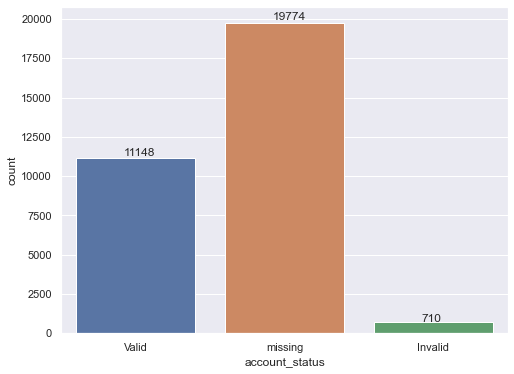

In [62]:
countplot(matched['account_status'], dropna=False)

In [40]:
# how many unique HCPs have 'account_status' information
matched.drop_duplicates(subset=['account_id'])['account_status'].count()

4367

In [32]:
# what is the distribution of those
matched.drop_duplicates(subset=['account_id'])['account_status'].value_counts()

Valid      4083
Invalid     284
Name: account_status, dtype: Int64

C:\Users\M302242\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


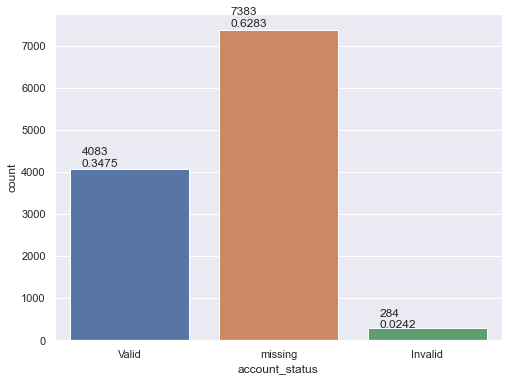

In [18]:
countplot(matched.drop_duplicates(subset=['account_id'])['account_status'], dropna=False)

C:\Users\M302242\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


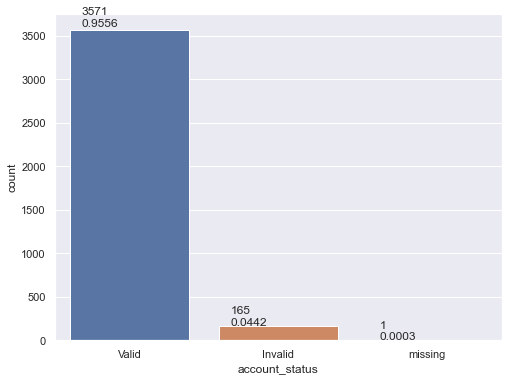

In [19]:
countplot(matched_ter.drop_duplicates(subset=['account_id'])['account_status'], dropna=False)

C:\Users\M302242\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


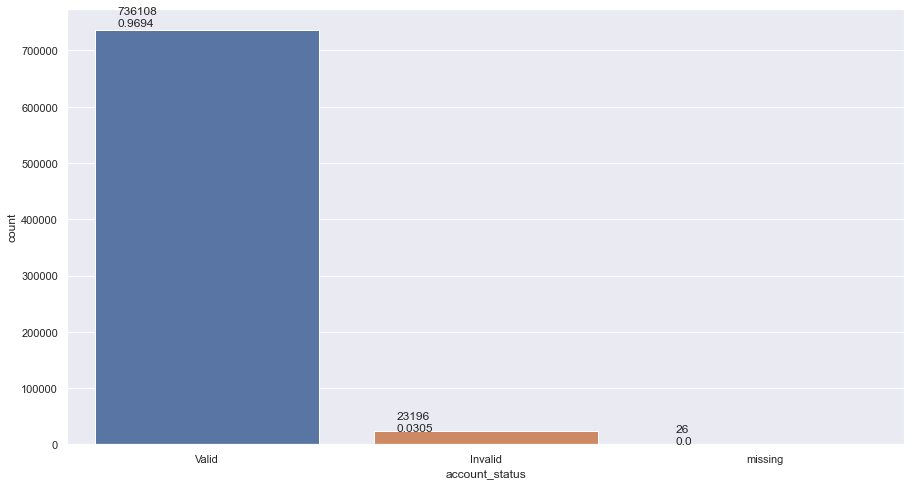

In [14]:
countplot(fd_dacc_ter['account_status'], dropna=False)

C:\Users\M302242\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


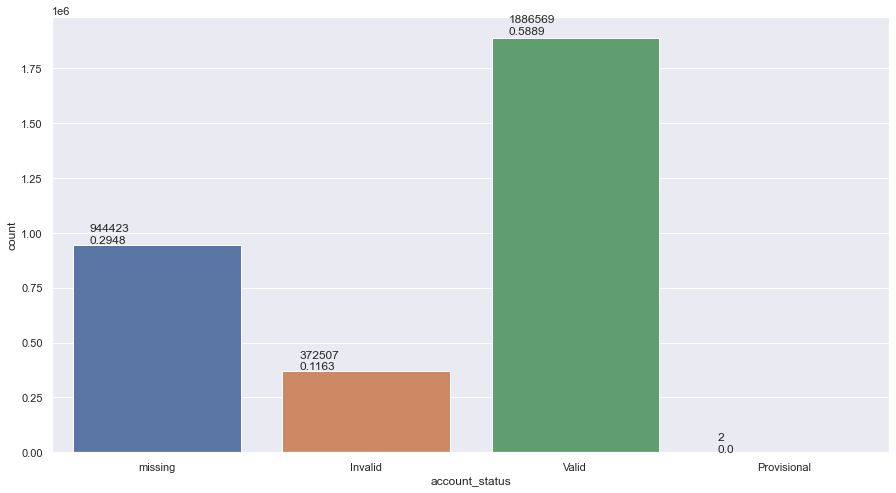

In [15]:
countplot(fd_dacc['account_status'], dropna=False)

=> for matched HCPs we don't really need to know if they're valid or not. We could however use this info to reduce overall number of HCPs in the full set.

##### digital affinity

In [82]:
fd_dacc_ter['digital_affinity'].unique()

array([nan, 'Low Affinity', 'High Affinity'], dtype=object)

C:\Users\M302242\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


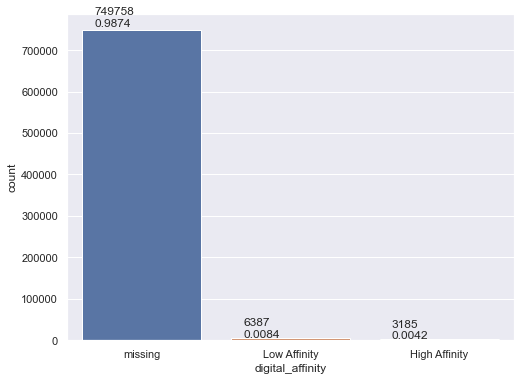

In [83]:
countplot(fd_dacc_ter['digital_affinity'], dropna=False)

C:\Users\M302242\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


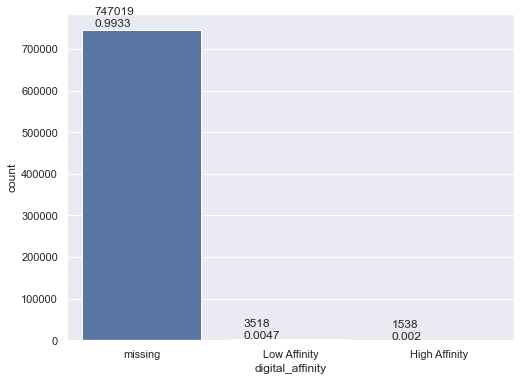

In [84]:
countplot(fd_dacc_ter.drop_duplicates('account_id')['digital_affinity'], dropna=False)

C:\Users\M302242\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


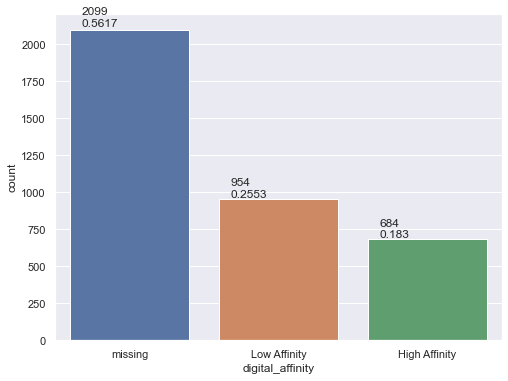

In [85]:
countplot(matched_ter.drop_duplicates('account_id')['digital_affinity'], dropna=False)

C:\Users\M302242\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


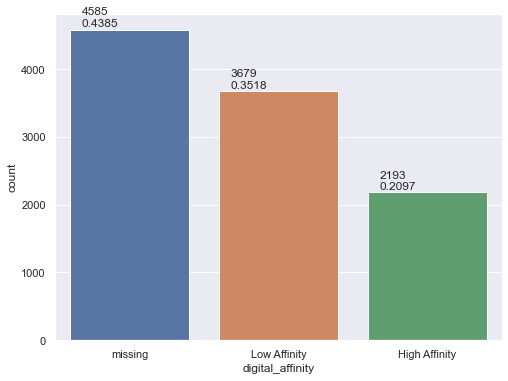

In [86]:
countplot(matched_ter['digital_affinity'], dropna=False)

The column is sparce. Absent values aren't correlated to other columns.

##### digital segmentation

In [22]:
fd_dacc_ter['digital_segmentation'].unique()

array([nan, 'Conventionalists', 'Not Segmented', 'Engagers',
       'Low Engagers', 'Digitally Engaged'], dtype=object)

C:\Users\M302242\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,count,percentage
missing,711549.0,93.71
Not Segmented,38209.0,5.03
Conventionalists,3969.0,0.52
Engagers,2616.0,0.34
Low Engagers,2418.0,0.32
Digitally Engaged,569.0,0.07


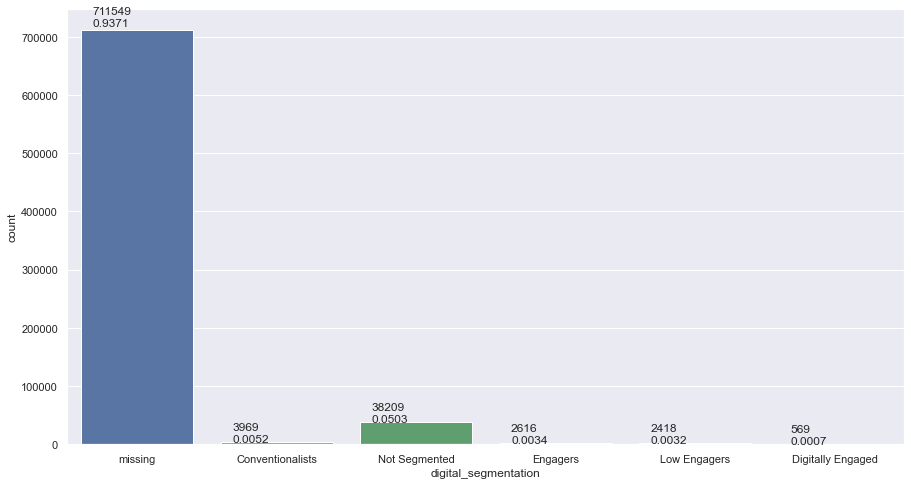

In [23]:
countplot(fd_dacc_ter['digital_segmentation'], dropna=False)
perc_counts(fd_dacc_ter['digital_segmentation'], dropna=False)

C:\Users\M302242\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\M302242\Anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,count,percentage
missing,710277.0,94.44
Not Segmented,36742.0,4.89
Conventionalists,1831.0,0.24
Low Engagers,1687.0,0.22
Engagers,1209.0,0.16
Digitally Engaged,329.0,0.04


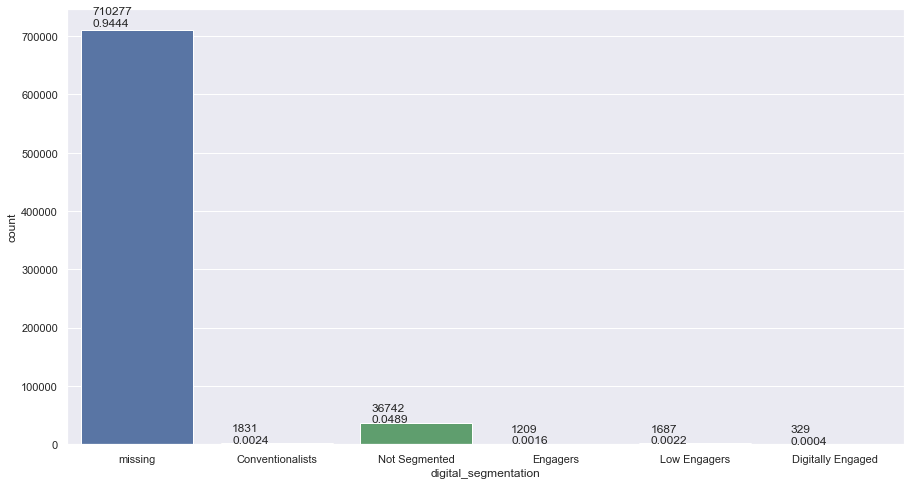

In [24]:
countplot(fd_dacc_ter.drop_duplicates("account_id")['digital_segmentation'], dropna=False)
perc_counts(fd_dacc_ter.drop_duplicates("account_id")['digital_segmentation'], dropna=False)

C:\Users\M302242\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,count,percentage
Conventionalists,2666.0,25.49
missing,2485.0,23.76
Not Segmented,2100.0,20.08
Engagers,1875.0,17.93
Low Engagers,1013.0,9.69
Digitally Engaged,318.0,3.04


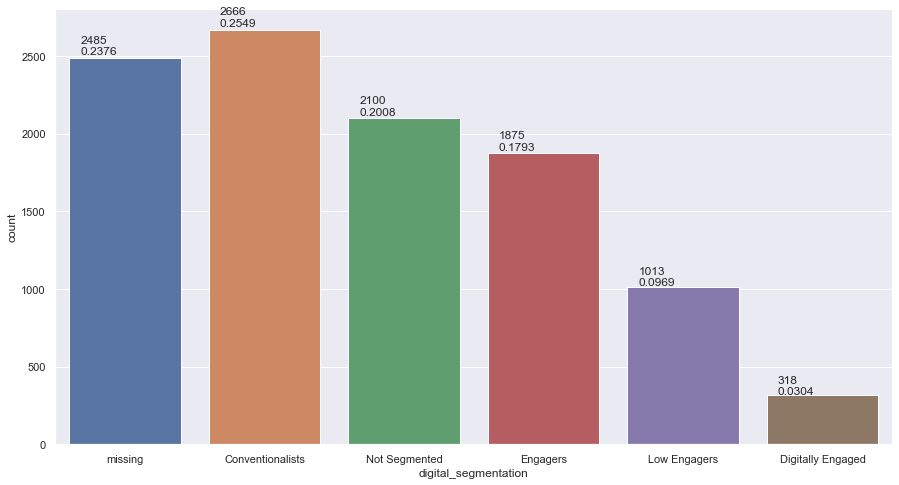

In [25]:
countplot(matched_ter['digital_segmentation'], dropna=False)
perc_counts(matched_ter['digital_segmentation'], dropna=False)

C:\Users\M302242\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\M302242\Anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,count,percentage
missing,1370.0,36.66
Not Segmented,729.0,19.51
Conventionalists,638.0,17.07
Engagers,590.0,15.79
Low Engagers,316.0,8.46
Digitally Engaged,94.0,2.52


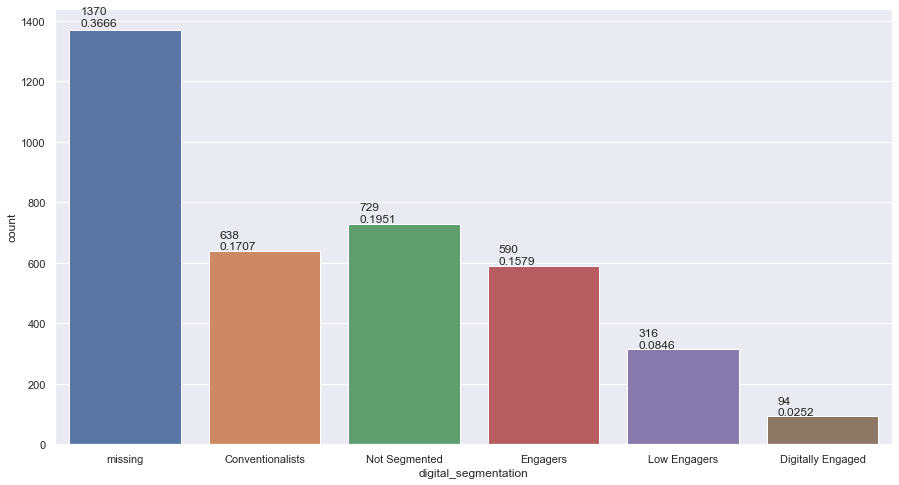

In [26]:
countplot(matched_ter.drop_duplicates("account_id")['digital_segmentation'], dropna=False)
perc_counts(matched_ter.drop_duplicates("account_id")['digital_segmentation'], dropna=False)

Also a sparce column. Still, since we have something like "not segmented" we can use this and the previos columns setting missing values to "Not Segmented".

##### hcp_franchise and _segment_key

In [7]:
fd_dacc['hcp_franchise'].unique()

array(['Neurology & Immunology', 'CM&E', 'Multi-Franchise', 'Oncology',
       'Fertility', nan], dtype=object)

We know: Thyroid -> CM&E, Multi+KAM -> Multi, Ertibux -> Oncology. Let's format this column directly and check for correlation with hcp_franchise


In [27]:
# unify the format for the full dataset
fd_dacc['hcp_franchise'].fillna('Multi-Franchise', inplace=True)
fd_dacc['_segment_key'].fillna('Multi-Franchise', inplace=True)

fd_dacc['_segment_key_unified'] = fd_dacc['_segment_key'].apply(lambda x: x.replace('Business Unit|', '') if isinstance(x, str) else 'Multi-Franchise')
# Since we have also some non-medical and not franchise recognizable units, we assign them to multi-franchise. Ofc it's also possible to dump them into some new franchise label, but for now we leave it like this.
d = {'Thyroid': 'CM&E', 'KAM - Campus M Pharma': 'Multi-Franchise', 'Ertibux': 'Oncology', 'Medical Event': 'Multi-Franchise', 'Industrial Pigments': 'Multi-Franchise'}
fd_dacc['_segment_key_unified'] = fd_dacc['_segment_key_unified'].apply(lambda x: d[x] if x in d.keys() else x)

In [16]:
# unify the format for territorial dataset
fd_dacc_ter['hcp_franchise'].fillna('Multi-Franchise', inplace=True)
fd_dacc_ter['_segment_key'].fillna('Multi-Franchise', inplace=True)

fd_dacc_ter['_segment_key_unified'] = fd_dacc_ter['_segment_key'].apply(lambda x: x.replace('Business Unit|', '') if isinstance(x, str) else 'Multi-Franchise')
# Since we have also some non-medical and not franchise recognizable units, we assign them to multi-franchise. Ofc it's also possible to dump them into some new franchise label, but for now we leave it like this.
d = {'Thyroid': 'CM&E', 'KAM - Campus M Pharma': 'Multi-Franchise', 'Ertibux': 'Oncology', 'Medical Event': 'Multi-Franchise', 'Industrial Pigments': 'Multi-Franchise'}
fd_dacc_ter['_segment_key_unified'] = fd_dacc_ter['_segment_key_unified'].apply(lambda x: d[x] if x in d.keys() else x)

In [18]:
fd_dacc['hcp_franchise'].value_counts()

Multi-Franchise           2107401
CM&E                       640051
Oncology                   231351
Neurology & Immunology     150920
Fertility                   73778
Name: hcp_franchise, dtype: int64

In [19]:
fd_dacc['_segment_key_unified'].value_counts()

Multi-Franchise           3172154
Fertility                   19754
CM&E                         7435
Oncology                     2829
Neurology & Immunology       1329
Name: _segment_key_unified, dtype: int64

Make correlation using label encoding

In [21]:
le_hcp_franchise = preprocessing.LabelEncoder()
le_segment_key = preprocessing.LabelEncoder()

le_hcp_franchise.fit(matched['hcp_franchise'].unique())
# le_segment_key.fit(fd_dacc['_segment_key'].unique())

transformed_hcp_franchise = le_hcp_franchise.transform(matched['hcp_franchise'])
transformed_segment_key = le_hcp_franchise.transform(fd_dacc[fd_dacc['_webinar_key'].notnull()]['_segment_key_unified'])

## TODO make correlation - done.

In [22]:
# how does it really look like?
fd_dacc[fd_dacc['_webinar_key'].notnull()][['hcp_franchise', '_segment_key_unified']]

,hcp_franchise,_segment_key_unified
927906,Multi-Franchise,Fertility
992883,Multi-Franchise,Fertility
1024935,Multi-Franchise,Fertility
1223983,CM&E,Fertility
1224029,Multi-Franchise,Oncology
...,...,...
3201307,Multi-Franchise,CM&E
3201308,Multi-Franchise,CM&E
3201309,Multi-Franchise,CM&E
3201310,Multi-Franchise,CM&E


In [24]:
pd.DataFrame(np.transpose([transformed_hcp_franchise, transformed_segment_key]), columns=['hcp_franchise', '_segment_key_unified']).corr()

,hcp_franchise,_segment_key_unified
hcp_franchise,1.000000,0.403091
_segment_key_unified,0.403091,1.000000


Make correlation using one_hot

In [31]:
OHE_df = pd.DataFrame()
OHE = preprocessing.OneHotEncoder()
transformed = OHE.fit_transform(fd_dacc[fd_dacc['_webinar_key'].notnull()][['hcp_franchise']])
print('Transformed categories: ' + str(OHE.categories_))
OHE_df[[i + '_hcp_franchise' for i in OHE.categories_[0]]] = transformed.toarray()

transformed = OHE.fit_transform(fd_dacc[fd_dacc['_webinar_key'].notnull()][['_segment_key_unified']])
print('Transformed categories: ' + str(OHE.categories_))

OHE_df[[i + '_segment_key' for i in OHE.categories_[0]]] = transformed.toarray()

Transformed categories: [array(['CM&E', 'Fertility', 'Multi-Franchise', 'Neurology & Immunology',
       'Oncology'], dtype=object)]
Transformed categories: [array(['CM&E', 'Fertility', 'Multi-Franchise', 'Neurology & Immunology',
       'Oncology'], dtype=object)]


<AxesSubplot:>

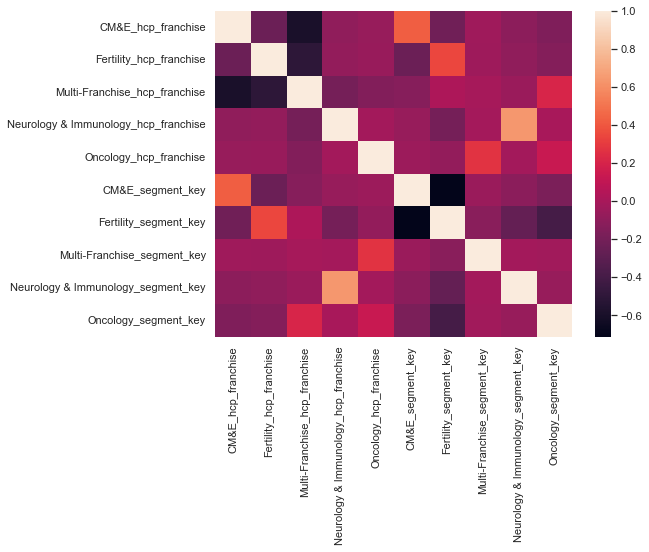

In [32]:
sns.heatmap(OHE_df.corr())

C:\Users\M302242\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


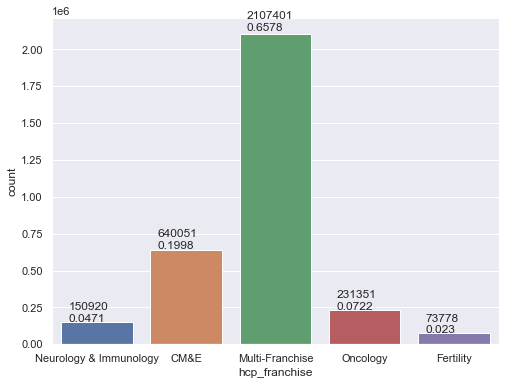

In [33]:
countplot(fd_dacc['hcp_franchise'], dropna=False)

Check possible set reduction for training splitting data by franchise or by franchise + country

In [24]:
print('>> Full set filtered by territory <<')
for f in fd_dacc_ter.groupby('hcp_franchise'):
    print(f'Franchise: {f[0]} ---> {f[1].shape[0]} entries ----> {f[1].drop_duplicates("account_id").shape[0]} unique HCPs')
print('\n>> Matched set filtered by territory <<')
for f in matched_ter.groupby('hcp_franchise'):
    print(f'Franchise: {f[0]} ---> {f[1].shape[0]} entries ----> {f[1].drop_duplicates("account_id").shape[0]} unique HCPs')

>> Full set filtered by territory <<
Franchise: CM&E ---> (253121, 74) entries ----> 250432 unique HCPs
Franchise: Fertility ---> (67394, 74) entries ----> 63627 unique HCPs
Franchise: Multi-Franchise ---> (560493, 74) entries ----> 560484 unique HCPs
Franchise: Neurology & Immunology ---> (107375, 74) entries ----> 106741 unique HCPs
Franchise: Oncology ---> (142118, 74) entries ----> 141987 unique HCPs

>> Matched set filtered by territory <<
Franchise: CM&E ---> (4391, 74) entries ----> 1928 unique HCPs
Franchise: Fertility ---> (4777, 74) entries ----> 1240 unique HCPs
Franchise: Multi-Franchise ---> (17, 74) entries ----> 13 unique HCPs
Franchise: Neurology & Immunology ---> (888, 74) entries ----> 306 unique HCPs
Franchise: Oncology ---> (338, 74) entries ----> 232 unique HCPs


##### hcp_therapeutic_area, specialty 1 and 2

In [34]:
fd_dacc['hcp_franchise'].unique()

array(['Neurology & Immunology', 'CM&E', 'Multi-Franchise', 'Oncology',
       'Fertility'], dtype=object)

In [41]:
# Observation: hcp_therapeutic_area contains some additional info, which could also be found in the _segment_key
fd_dacc['hcp_therapeutic_area'].unique()

array([nan, 'Fertility - Cetrotide', 'Fertility - Ovidrel',
       'Endocrinology - Saizen', 'GM&E - Diabetes', 'GM&E - Thyroids',
       'GM&E - Dermatology', 'GM&E - Cardiology',
       'Fertility Tech - General', 'Fertility - General',
       'Oncology - General', 'Neurology - General', 'GM&E - General',
       'Neurology - Rebif', 'Endocrinology - General',
       'Oncology - Avelumab MCC', 'Oncology - Avelumab Gastric',
       'Oncology - Erbitux CRC', 'Endocrinology - Eutirox',
       'Oncology - Erbitux H&N', 'CMC - General', 'Oncology - Erbitux',
       'Fertility - Luveris', 'Pharmacist - Pharmacist',
       'Neurology - Cladribine Tablets', 'Oncology - Avelumab Lung',
       'Fertility - Gonal-F', 'Oncology - Avelumab Bladder',
       'Fertility - Pergoveris', 'Oncology - Avelumab Ovarian'],
      dtype=object)

In [35]:
fd_dacc[fd_dacc['hcp_franchise'] == 'Fertility']['hcp_therapeutic_area'].unique()

array([nan, 'Fertility - Cetrotide', 'Fertility - Ovidrel',
       'Fertility - General', 'Fertility Tech - General',
       'Neurology - General', 'GM&E - Diabetes', 'GM&E - Thyroids',
       'Oncology - General', 'Endocrinology - Saizen',
       'Endocrinology - General', 'GM&E - General', 'GM&E - Dermatology',
       'GM&E - Cardiology', 'Pharmacist - Pharmacist',
       'Fertility - Gonal-F'], dtype=object)

In [36]:
fd_dacc_ter[fd_dacc_ter['hcp_franchise'] == 'Fertility']['hcp_therapeutic_area'].value_counts()

Fertility - General         6293
Fertility Tech - General     204
Oncology - General            30
GM&E - General                13
GM&E - Thyroids               11
Endocrinology - General        7
GM&E - Diabetes                6
GM&E - Dermatology             3
Endocrinology - Saizen         2
Fertility - Cetrotide          1
Neurology - General            1
Fertility - Ovidrel            1
GM&E - Cardiology              1
Pharmacist - Pharmacist        1
Fertility - Gonal-F            1
Name: hcp_therapeutic_area, dtype: int64

In [40]:
# Observation: something very weird is happening between "hcp_franchise" and "hcp_therapeutic_area"!
fd_dacc[fd_dacc['hcp_franchise'] == 'CM&E']['hcp_therapeutic_area'].unique()

array([nan, 'GM&E - Diabetes', 'GM&E - Dermatology', 'GM&E - Cardiology',
       'Neurology - General', 'GM&E - Thyroids', 'Fertility - General',
       'GM&E - General', 'Oncology - General', 'Endocrinology - Saizen',
       'Endocrinology - General', 'Fertility Tech - General',
       'Oncology - Erbitux CRC', 'Fertility - Ovidrel',
       'Endocrinology - Eutirox', 'Oncology - Erbitux',
       'Neurology - Rebif', 'Oncology - Avelumab MCC',
       'Oncology - Erbitux H&N', 'Fertility - Pergoveris',
       'CMC - General', 'Neurology - Cladribine Tablets'], dtype=object)

In [15]:
fd_dacc_ter[fd_dacc_ter['hcp_franchise'] == 'CM&E']['hcp_therapeutic_area'].value_counts()

GM&E - General                    4943
GM&E - Diabetes                   1893
GM&E - Dermatology                1623
GM&E - Cardiology                 1347
GM&E - Thyroids                   1241
Endocrinology - General            561
Endocrinology - Saizen             498
Fertility - General                305
Oncology - General                 161
Neurology - General                 99
Fertility - Ovidrel                 69
Fertility Tech - General            33
Neurology - Rebif                    8
Endocrinology - Eutirox              7
CMC - General                        6
Oncology - Erbitux                   4
Oncology - Avelumab MCC              3
Fertility - Pergoveris               2
Oncology - Erbitux CRC               1
Neurology - Cladribine Tablets       1
Name: hcp_therapeutic_area, dtype: int64

Possible explanation: the absolute majority of the HCPs have same therapeutic area as their franchise, still there're some entries that are suspicious

In [41]:
# Take a better look on those HCPs, whose franchise doesn't match their therapeutic area
for f in fd_dacc_ter['hcp_franchise'].unique():
    franchise = fd_dacc_ter[fd_dacc_ter['hcp_franchise'] == f]
    display(franchise[~franchise['hcp_therapeutic_area'].fillna(f).str.contains(f)])

,_account_key,account,account_city,account_country,account_country_code,account_email,account_inkl_onekey,account_latitude,account_longitude,account_state,account_status,account_type,account_id,digital_affinity,digital_segmentation,gender,hcp_franchise,hcp_therapeutic_area,ispersonaccount,onekey_id,specialty_1,specialty_2,veeva_id,account_brick,account_territories,account_territories_per_bu,_account_key_fdweb,account_key_original,account_id_na,_webinar_key,_calendar_key,_product_key,_segment_key,_country_key,_channel_key,_campaign_key,account_cnt,webinar_participants_cnt,event_allchannels_cnt,_fact_allchannels_event,_has_campaign_id,_webinar_has_web_campaign,webinar_cnt,_timeline_key,attendence_type,_attended,_fulltimeattended,stream_time,user_rating,user_benefit_rate,source_system,_mslteam,_datasource_f_webinars,fact_source_,_fact_actual,_testaccount,_individualcustomer,_function_key,fact_function,_franchiseviewtimeline_key,_remoteevent,_f2fevent,fact_country,webinar_fileextension,webinar_filename,webinar_duration,webinar_name,webinar_platform,account_id_fdweb,account_id_webinar,date,webinar_registered,webinar_latitude,webinar_longitude
1224045,EMEA_Veeva|0012o00002Xq1fYAAR,VALERIE DOUAT,AURILLAC,France,FR,valerie.douat@wanadoo.fr,VALERIE DOUAT - WFRM02726055,44.918186,2.425550,NaN,Valid,NaN,0012o00002Xq1fYAAR,NaN,NaN,NaN,CM&E,GM&E - Cardiology,True,WFRM02726055,Endocrinology,Diabetology,0012o00002Xq1fYAAR,UG2.WFR.15AUR,T7-FR-RMR-MG&E-FE;T8-FR-EN0201;T8-FR...,T8-FR-EN0201,EMEA_Veeva,valerie.douat@wanadoo.fr,False,786.0,44663.0,NaN,Business Unit|CM&E,FR,Webinar,NaN,EMEA_Veeva|0012o00002Xq1fYAAR,160849.0,F_Webinar|160849,1.0,0.0,1.0,160612.0,Webinar|160612,Live,1.0,1.0,87.32,NaN,NaN,Webinar Excel,0.0,1.0,F_Webinars,1.0,0.0,1.0,Commercial,Commercial,WebinarCommercial44663|44663|Webinar...,1.0,NaN,France,csv,96260141060_2022-04-12-16-09-26.csv,60.0,Webinar - Explorations thyroïdiennes...,Zoom,NaN,NaN,NaN,NaN,NaN,NaN
1224459,EMEA_Veeva|0012o00002XpFGAAA3,FREDERIQUE FRETE,LIBOURNE CEDEX,France,FR,caroline.frete@ch-libourne.fr,FREDERIQUE FRETE - WFRM00044847,44.920219,-0.229472,NaN,Valid,NaN,0012o00002XpFGAAA3,NaN,NaN,NaN,CM&E,GM&E - Thyroids,True,WFRM00044847,Endocrinology,Diabetology,0012o00002XpFGAAA3,UG2.WFR.33LIB,T7-FR-RMR-MG&E-FE;T8-FR-EN0203;T8-FR...,T8-FR-EN0203,EMEA_Veeva,caroline.frete@ch-libourne.fr,False,274.0,44350.0,NaN,Business Unit|CM&E,FR,Webinar,NaN,EMEA_Veeva|0012o00002XpFGAAA3,82208.0,F_Webinar|82208,1.0,0.0,1.0,82053.0,Webinar|82053,Live,1.0,0.0,55.02,NaN,NaN,Webinar Excel,1.0,1.0,F_Webinars,1.0,0.0,1.0,Medical,Medical,WebinarMedical44350|44350|Webinar|FR...,1.0,NaN,France,csv,5738667098.csv,90.0,Orbitopathie Basedowienne - session2,Adobe Connect,NaN,NaN,NaN,NaN,NaN,NaN
1224879,EMEA_Veeva|0012o00002XrgaUAAR,SOPHIE OUZOUNIAN,QUINCY SOUS SENART,France,FR,sophie.ouzounian2@gmail.com,SOPHIE OUZOUNIAN - WFRM09755431,48.681660,2.539497,NaN,Valid,NaN,0012o00002XrgaUAAR,NaN,NaN,NaN,CM&E,Oncology - General,True,WFRM09755431,Endocrinology,Diabetology,0012o00002XrgaUAAR,UG2.WFR.91YER,T8-FR-EN0101;T8-FR-EN0102;T8-FR-EN01...,T8-FR-FE0103;T8-FR-FE0104;T8-FR-FE02...,EMEA_Veeva,sophie.ouzounian2@gmail.com,False,203.0,44138.0,NaN,Business Unit|CM&E,UK,Webinar,NaN,EMEA_Veeva|0012o00002XrgaUAAR,67600.0,NaN,NaN,0.0,1.0,67399.0,Webinar|67399,NaN,0.0,0.0,0.00,NaN,NaN,Webinar Excel,1.0,1.0,F_Webinars,1.0,0.0,1.0,Medical,Medical,WebinarMedical44138|44138|Webinar|UK...,1.0,NaN,NaN,csv,4998994681.csv,90.0,Thyroïde et perturbateurs endocrinie...,Adobe Connect,NaN,NaN,NaN,NaN,NaN,NaN
1226270,EMEA_Veeva|0012o00002Xpcu9AAB,CHADI ANDRE LACADE,LA VALETTE DU VAR,France,FR,drlacade.endocrino@hotmail.com,CHADI ANDRE LACADE - WFRM00460700,43.139769,6.010168,NaN,Valid,NaN,0012o00002Xpcu9AAB,NaN,NaN,NaN,CM&E,Endocrinology - General,True,WFRM00460700,Endocrinology,NaN,0012o00002Xpcu9AAB,UG2.WFR.83LGA,T8-FR-EN0206;T8-FR-FE0305;T8-FR-MGFR...,T8-FR-EN0206,EMEA_Veeva,drlacade.endocrino@hotmail.com,False,203.0,44138.0,NaN,Business Unit|CM&E,UK,Webinar,NaN

,_account_key,account,account_city,account_country,account_country_code,account_email,account_inkl_onekey,account_latitude,account_longitude,account_state,account_status,account_type,account_id,digital_affinity,digital_segmentation,gender,hcp_franchise,hcp_therapeutic_area,ispersonaccount,onekey_id,specialty_1,specialty_2,veeva_id,account_brick,account_territories,account_territories_per_bu,_account_key_fdweb,account_key_original,account_id_na,_webinar_key,_calendar_key,_product_key,_segment_key,_country_key,_channel_key,_campaign_key,account_cnt,webinar_participants_cnt,event_allchannels_cnt,_fact_allchannels_event,_has_campaign_id,_webinar_has_web_campaign,webinar_cnt,_timeline_key,attendence_type,_attended,_fulltimeattended,stream_time,user_rating,user_benefit_rate,source_system,_mslteam,_datasource_f_webinars,fact_source_,_fact_actual,_testaccount,_individualcustomer,_function_key,fact_function,_franchiseviewtimeline_key,_remoteevent,_f2fevent,fact_country,webinar_fileextension,webinar_filename,webinar_duration,webinar_name,webinar_platform,account_id_fdweb,account_id_webinar,date,webinar_registered,webinar_latitude,webinar_longitude
1281709,EMEA_Veeva|0012o00002XpoYfAAJ,MOHAMED BENAHMED,NICE CEDEX 3,France,FR,esocquard@wanadoo.fr,MOHAMED BENAHMED - WFRM00945021,43.697593,7.226676,NaN,Valid,NaN,0012o00002XpoYfAAJ,NaN,NaN,NaN,Oncology,Endocrinology - General,True,WFRM00945021,Biology,NaN,0012o00002XpoYfAAJ,UG2.WFR.06NC2,T8-FR-EN0206;T8-FR-FE0305;T8-FR-MGFR...,T8-FR-MGFR,EMEA_Veeva,esocquard@wanadoo.fr,False,274.0,44350.0,NaN,Business Unit|CM&E,FR,Webinar,NaN,EMEA_Veeva|0012o00002XpoYfAAJ,82216.0,F_Webinar|82216,1.0,0.0,1.0,82053.0,Webinar|82053,Live,1.0,0.0,63.37,NaN,NaN,Webinar Excel,1.0,1.0,F_Webinars,1.0,0.0,1.0,Medical,Medical,WebinarMedical44350|44350|Webinar|FR...,1.0,NaN,France,csv,5738667098.csv,90.0,Orbitopathie Basedowienne - session2,Adobe Connect,NaN,NaN,NaN,NaN,NaN,NaN
1281710,EMEA_Veeva|0012o00002XpoYfAAJ,MOHAMED BENAHMED,NICE CEDEX 3,France,FR,esocquard@wanadoo.fr,MOHAMED BENAHMED - WFRM00945021,43.697593,7.226676,NaN,Valid,NaN,0012o00002XpoYfAAJ,NaN,NaN,NaN,Oncology,Endocrinology - General,True,WFRM00945021,Biology,NaN,0012o00002XpoYfAAJ,UG2.WFR.06NC2,T8-FR-EN0206;T8-FR-FE0305;T8-FR-MGFR...,T8-FR-MGFR,EMEA_Veeva,esocquard@wanadoo.fr,False,786.0,44663.0,NaN,Business Unit|CM&E,FR,Webinar,NaN,EMEA_Veeva|0012o00002XpoYfAAJ,161036.0,F_Webinar|161036,1.0,0.0,1.0,160612.0,Webinar|160612,Live,1.0,1.0,79.23,NaN,NaN,Webinar Excel,0.0,1.0,F_Webinars,1.0,0.0,1.0,Commercial,Commercial,WebinarCommercial44663|44663|Webinar...,1.0,NaN,France,csv,96260141060_2022-04-12-16-09-26.csv,60.0,Webinar - Explorations thyroïdiennes...,Zoom,NaN,NaN,NaN,NaN,NaN,NaN
1304160,EMEA_Veeva|0012o00002Xq5MqAAJ,VALENTINA GUARINO,TROYES CEDEX,France,FR,valentina.guarino@ch-troyes.fr,VALENTINA GUARINO - WFRM03297947,48.278965,4.068844,NaN,Valid,NaN,0012o00002Xq5MqAAJ,NaN,NaN,NaN,Oncology,GM&E - General,True,WFRM03297947,Hospital Pharmacy,NaN,0012o00002Xq5MqAAJ,UG2.WFR.10TRO,T7-FR-RMR-ON;T8-FR-MA0103;T8-FR-MGFR...,T8-FR-MA0103;T8-FR-MGFR,EMEA_Veeva,valentina.guarino@ch-troyes.fr,False,267.0,44468.0,NaN,Business Unit|KAM - Campus M Pharma,FR,Webinar,NaN,EMEA_Veeva|0012o00002Xq5MqAAJ,80761.0,F_Webinar|80761,1.0,0.0,1.0,80607.0,Webinar|80607,Live,1.0,0.0,71.47,NaN,NaN,Webinar Excel,0.0,1.0,F_Webinars,1.0,0.0,1.0,Commercial,Commercial,WebinarCommercial44468|44468|Webinar...,1.0,NaN,France,csv,5659061966.csv,180.0,Campus M Pharma,Adobe Connect,NaN,NaN,NaN,NaN,NaN,NaN
1344705,EMEA_Veeva|0012o00002XLN4iAAH,Emad Elnashar,Azizeya,Saudi Arabia,SA,el_nashar@hotmail.com,Emad Elnashar - WSAM00002218,21.385153,39.860506,NaN,Valid,NaN,0012o00002XLN4iAAH,High Affinity,Engagers,NaN,Oncology,GM&E - General,True,WSAM00002218,Oncology,NaN,0012o00002XLN4iAAH,UG1.WSA.17,T5 - KSA - Medical Manager Oncology;...,T5 - KSA - Medical Manager Oncology,EMEA_Veeva,el_nashar@hotmail.com,False,808.0,44512.0,NaN,Business Unit|Oncology,SA,Webinar,NaN,EMEA_Veeva|0012o00002XLN4iAAH,1

,_account_key,account,account_city,account_country,account_country_code,account_email,account_inkl_onekey,account_latitude,account_longitude,account_state,account_status,account_type,account_id,digital_affinity,digital_segmentation,gender,hcp_franchise,hcp_therapeutic_area,ispersonaccount,onekey_id,specialty_1,specialty_2,veeva_id,account_brick,account_territories,account_territories_per_bu,_account_key_fdweb,account_key_original,account_id_na,_webinar_key,_calendar_key,_product_key,_segment_key,_country_key,_channel_key,_campaign_key,account_cnt,webinar_participants_cnt,event_allchannels_cnt,_fact_allchannels_event,_has_campaign_id,_webinar_has_web_campaign,webinar_cnt,_timeline_key,attendence_type,_attended,_fulltimeattended,stream_time,user_rating,user_benefit_rate,source_system,_mslteam,_datasource_f_webinars,fact_source_,_fact_actual,_testaccount,_individualcustomer,_function_key,fact_function,_franchiseviewtimeline_key,_remoteevent,_f2fevent,fact_country,webinar_fileextension,webinar_filename,webinar_duration,webinar_name,webinar_platform,account_id_fdweb,account_id_webinar,date,webinar_registered,webinar_latitude,webinar_longitude
1245964,EMEA_Veeva|0012o00002XpBhAAAV,CECILE PRETERRE,ST HERBLAIN,France,FR,cecile.preterre@chu-nantes.fr,CECILE PRETERRE - WFRM00031711,47.247692,-1.634931,NaN,Valid,NaN,0012o00002XpBhAAAV,NaN,NaN,NaN,Neurology & Immunology,Neurology - General,True,WFRM00031711,Neurology,NaN,0012o00002XpBhAAAV,UG2.WFR.44SHE,T7-FR-RMP-NE;T7-FR-RMP-NE_1;T8-FR-MG...,T8-FR-MGFR,EMEA_Veeva,cecile.preterre@chu-nantes.fr,False,161.0,44019.0,NaN,Business Unit|CM&E,UK,Webinar,NaN,EMEA_Veeva|0012o00002XpBhAAAV,59111.0,F_Webinar|59111,1.0,0.0,1.0,59030.0,Webinar|59030,Live,1.0,0.0,16.27,NaN,NaN,Webinar Excel,1.0,1.0,F_Webinars,1.0,0.0,1.0,Medical,Medical,WebinarMedical44019|44019|Webinar|UK...,1.0,NaN,NaN,csv,4843533850.csv,120.0,M Webinar\nCovid-19 et atteintes neu...,Adobe Connect,NaN,NaN,NaN,NaN,NaN,NaN
1256261,EMEA_Veeva|0012o00002XpbrXAAR,MOHAMED ABDELLAOUI,PARIS CEDEX 12,France,FR,momodoc94@hotmail.com,MOHAMED ABDELLAOUI - WFRM00303205,48.849999,2.382893,NaN,Valid,NaN,0012o00002XpbrXAAR,NaN,NaN,NaN,Neurology & Immunology,Neurology - General,True,WFRM00303205,Neurology,NaN,0012o00002XpbrXAAR,UG2.WFR.75NAT,T7-FR-RMP-NE;T7-FR-RMP-NE_1;T7-FR-RM...,T8-FR-MGFR,EMEA_Veeva,momodoc94@hotmail.com,False,151.0,44006.0,NaN,Business Unit|CM&E,UK,Webinar,NaN,EMEA_Veeva|0012o00002XpbrXAAR,56883.0,NaN,NaN,0.0,1.0,56757.0,Webinar|56757,NaN,0.0,0.0,0.00,NaN,NaN,Webinar Excel,1.0,1.0,F_Webinars,1.0,0.0,1.0,Medical,Medical,WebinarMedical44006|44006|Webinar|UK...,1.0,NaN,NaN,csv,4796740183.csv,120.0,La crise du Covid-19 : un accélérate...,Adobe Connect,NaN,NaN,NaN,NaN,NaN,NaN
1268792,EMEA_Veeva|0012o00002Xp5A3AAJ,AURORE JOURDAIN,BREST CEDEX 2,France,FR,aurore.jourdain@chu-brest.fr,AURORE JOURDAIN - WFRM00001347,48.396770,-4.532531,NaN,Valid,NaN,0012o00002Xp5A3AAJ,NaN,NaN,NaN,Neurology & Immunology,Neurology - General,True,WFRM00001347,Neurology,NaN,0012o00002Xp5A3AAJ,UG2.WFR.29GUI,T7-FR-RMP-NE;T7-FR-RMP-NE_1;T7-FR-RM...,T8-FR-MGFR,EMEA_Veeva,aurore.jourdain@chu-brest.fr,False,161.0,44019.0,NaN,Business Unit|CM&E,UK,Webinar,NaN,EMEA_Veeva|0012o00002Xp5A3AAJ,59159.0,NaN,NaN,0.0,1.0,59030.0,Webinar|59030,NaN,0.0,0.0,0.00,NaN,NaN,Webinar Excel,1.0,1.0,F_Webinars,1.0,0.0,1.0,Medical,Medical,WebinarMedical44019|44019|Webinar|UK...,1.0,NaN,NaN,csv,4843533850.csv,120.0,M Webinar\nCovid-19 et atteintes neu...,Adobe Connect,NaN,NaN,NaN,NaN,NaN,NaN
1268922,EMEA_Veeva|0012o00002Xp5aZAAR,CATHERINE CORNUT CHAUVINC,LYON,France,FR,catherine.cornutchauvinc@gmail.com,CATHERINE CORNUT CHAUVINC - WFRM0000...,45.742434,4.876129,NaN,Valid,NaN,0012o00002Xp5aZAAR,NaN,NaN,NaN,Neurology & Immunology,Neurology - General,True,WFRM00003345,Neurology,NaN,0012o00002Xp5aZAAR,UG2.WFR.69LY4,T7-FR-RMP-NE;T7-FR-RMP-NE_1;T8-FR-MG...,T7-FR-RMP-NE;T7-FR-RMP-NE_1;T8-FR-NE...,EMEA_Veeva,catherine.cornutchauvinc@gmail.com,False,161.0,44019.0,NaN,Business Unit|CM&E,UK,Webinar,N

,_account_key,account,account_city,account_country,account_country_code,account_email,account_inkl_onekey,account_latitude,account_longitude,account_state,account_status,account_type,account_id,digital_affinity,digital_segmentation,gender,hcp_franchise,hcp_therapeutic_area,ispersonaccount,onekey_id,specialty_1,specialty_2,veeva_id,account_brick,account_territories,account_territories_per_bu,_account_key_fdweb,account_key_original,account_id_na,_webinar_key,_calendar_key,_product_key,_segment_key,_country_key,_channel_key,_campaign_key,account_cnt,webinar_participants_cnt,event_allchannels_cnt,_fact_allchannels_event,_has_campaign_id,_webinar_has_web_campaign,webinar_cnt,_timeline_key,attendence_type,_attended,_fulltimeattended,stream_time,user_rating,user_benefit_rate,source_system,_mslteam,_datasource_f_webinars,fact_source_,_fact_actual,_testaccount,_individualcustomer,_function_key,fact_function,_franchiseviewtimeline_key,_remoteevent,_f2fevent,fact_country,webinar_fileextension,webinar_filename,webinar_duration,webinar_name,webinar_platform,account_id_fdweb,account_id_webinar,date,webinar_registered,webinar_latitude,webinar_longitude
1285452,EMEA_Veeva|0012o00002a4aLQAAY,MICAELA MARGUERITA WILD,NICE CEDEX 3,France,FR,micaela.marguerita@orange.fr,MICAELA MARGUERITA WILD - WFRM09385950,43.697593,7.226676,NaN,Invalid,NaN,0012o00002a4aLQAAY,NaN,NaN,NaN,Fertility,Endocrinology - General,True,WFRM09385950,Endocrinology,Sexology,0012o00002a4aLQAAY,UG2.WFR.06NC2,T8-FR-RMR-MG&E-FE_4,T8-FR-RMR-MG&E-FE_4,EMEA_Veeva,micaela.marguerita@orange.fr,False,201.0,44138.0,NaN,Business Unit|CM&E,UK,Webinar,NaN,EMEA_Veeva|0012o00002a4aLQAAY,67020.0,NaN,NaN,0.0,1.0,66883.0,Webinar|66883,NaN,0.0,0.0,0.00,NaN,NaN,Webinar Excel,1.0,1.0,F_Webinars,1.0,0.0,1.0,Medical,Medical,WebinarMedical44138|44138|Webinar|UK...,1.0,NaN,NaN,csv,4998940566.csv,120.0,Thyroïde et perturbateurs endocrinie...,Adobe Connect,NaN,NaN,NaN,NaN,NaN,NaN
1366964,EMEA_Veeva|0012o00002zzU3tAAE,Sarah Madani,Ouargla,Algeria,DZ,sarahnelly9@hotmail.com,Sarah Madani - WDZM00085056,NaN,NaN,NaN,Valid,NaN,0012o00002zzU3tAAE,NaN,Not Segmented,NaN,Fertility,Oncology - General,True,WDZM00085056,Oncology,NaN,0012o00002zzU3tAAE,UG3.WDZ.30000,T8-NAF-MA1C,T8-NAF-MA1C,EMEA_Veeva,sarahnelly9@hotmail.com,False,636.0,44648.0,NaN,Business Unit|Oncology,DZ,Webinar,NaN,EMEA_Veeva|0012o00002zzU3tAAE,134258.0,NaN,NaN,0.0,1.0,134076.0,Webinar|134076,Live,0.0,0.0,0.00,NaN,NaN,Webinar Excel,0.0,1.0,F_Webinars,1.0,0.0,1.0,Commercial,Commercial,WebinarCommercial44648|44648|Webinar...,1.0,NaN,Algeria,csv,92826473505_2022-03-28-10-05-38.csv,71.0,STATE OF THE ART IN mCRC,Zoom,NaN,NaN,NaN,NaN,NaN,NaN
1366965,EMEA_Veeva|0012o00002zzU3tAAE,Sarah Madani,Ouargla,Algeria,DZ,sarahnelly9@hotmail.com,Sarah Madani - WDZM00085056,NaN,NaN,NaN,Valid,NaN,0012o00002zzU3tAAE,NaN,Not Segmented,NaN,Fertility,Oncology - General,True,WDZM00085056,Oncology,NaN,0012o00002zzU3tAAE,UG3.WDZ.30000,T8-NAF-MA1C,T8-NAF-MA1C,EMEA_Veeva,sarahnelly9@hotmail.com,False,637.0,44648.0,NaN,Business Unit|Oncology,DZ,Webinar,NaN,EMEA_Veeva|0012o00002zzU3tAAE,134378.0,NaN,NaN,0.0,1.0,134271.0,Webinar|134271,Live,0.0,0.0,0.00,NaN,NaN,Webinar Excel,0.0,1.0,F_Webinars,1.0,0.0,1.0,Commercial,Commercial,WebinarCommercial44648|44648|Webinar...,1.0,NaN,Algeria,csv,92826473505_2022-03-28-11-25-43.csv,300.0,STATE OF THE ART IN mCRC,Zoom,NaN,NaN,NaN,NaN,NaN,NaN
1372943,EMEA_Veeva|0012o00002XrfFxAAJ,ISABELLE HERON,BOIS GUILLAUME CEDEX,France,FR,isa.heron@gmail.com,ISABELLE HERON - WFRM04572837,49.462206,1.122026,NaN,Valid,NaN,0012o00002XrfFxAAJ,NaN,NaN,NaN,Fertility,GM&E - Thyroids,True,WFRM04572837,Gynaecology,Endocrinology,0012o00002XrfFxAAJ,UG2.WFR.76MSA,T8-FR-EN0103;T8-FR-FE0201;T8-FR-MGFR...,T8-FR-EN0103,EMEA_Veeva,isa.heron@gmail.com,False,203.0,44138.0,NaN,Business Unit|CM&E,UK,Webinar,NaN,EMEA_Veeva|0012o00002XrfFxAAJ,67665.0,F_Webinar|67665,1.0,0.0,1.0,67399.0,Webinar|67399,Live,1.0,0.0,36.52,NaN,NaN,Webinar Excel,1.0,1.0,F_Webinars,1.0,0.0,1.0,Medica

,_account_key,account,account_city,account_country,account_country_code,account_email,account_inkl_onekey,account_latitude,account_longitude,account_state,account_status,account_type,account_id,digital_affinity,digital_segmentation,gender,hcp_franchise,hcp_therapeutic_area,ispersonaccount,onekey_id,specialty_1,specialty_2,veeva_id,account_brick,account_territories,account_territories_per_bu,_account_key_fdweb,account_key_original,account_id_na,_webinar_key,_calendar_key,_product_key,_segment_key,_country_key,_channel_key,_campaign_key,account_cnt,webinar_participants_cnt,event_allchannels_cnt,_fact_allchannels_event,_has_campaign_id,_webinar_has_web_campaign,webinar_cnt,_timeline_key,attendence_type,_attended,_fulltimeattended,stream_time,user_rating,user_benefit_rate,source_system,_mslteam,_datasource_f_webinars,fact_source_,_fact_actual,_testaccount,_individualcustomer,_function_key,fact_function,_franchiseviewtimeline_key,_remoteevent,_f2fevent,fact_country,webinar_fileextension,webinar_filename,webinar_duration,webinar_name,webinar_platform,account_id_fdweb,account_id_webinar,date,webinar_registered,webinar_latitude,webinar_longitude
1269991,EMEA_Veeva|0012o00002a4y1JAAQ,THIERRY GERAUD,PERPIGNAN,France,FR,t.geraud@deenova.com,THIERRY GERAUD - WFRP05274774,42.684922,2.875010,NaN,Valid,NaN,0012o00002a4y1JAAQ,NaN,NaN,NaN,Multi-Franchise,Oncology - General,True,WFRP05274774,Pharmacy,NaN,0012o00002a4y1JAAQ,UG2.WFR.66PE1,T8-FR-MGFR,T8-FR-MGFR,EMEA_Veeva,t.geraud@deenova.com,False,267.0,44468.0,NaN,Business Unit|KAM - Campus M Pharma,FR,Webinar,NaN,EMEA_Veeva|0012o00002a4y1JAAQ,80633.0,F_Webinar|80633,1.0,0.0,1.0,80607.0,Webinar|80607,Live,1.0,0.0,54.83,NaN,NaN,Webinar Excel,0.0,1.0,F_Webinars,1.0,0.0,1.0,Commercial,Commercial,WebinarCommercial44468|44468|Webinar...,1.0,NaN,France,csv,5659061966.csv,180.0,Campus M Pharma,Adobe Connect,NaN,NaN,NaN,NaN,NaN,NaN
1270394,EMEA_Veeva|0012o00002a58b8AAA,ERIC ZANEA,PARIS,France,FR,eric.zanea@gmail.com,ERIC ZANEA - WFRP09858217,48.848246,2.297249,NaN,Valid,NaN,0012o00002a58b8AAA,NaN,NaN,NaN,Multi-Franchise,Oncology - General,True,WFRP09858217,Pharmacy,NaN,0012o00002a58b8AAA,UG2.WFR.75GRE,T8-FR-MGFR,T8-FR-MGFR,EMEA_Veeva,eric.zanea@gmail.com,False,267.0,44468.0,NaN,Business Unit|KAM - Campus M Pharma,FR,Webinar,NaN,EMEA_Veeva|0012o00002a58b8AAA,80665.0,NaN,NaN,0.0,1.0,80607.0,Webinar|80607,NaN,0.0,0.0,0.00,NaN,NaN,Webinar Excel,0.0,1.0,F_Webinars,1.0,0.0,1.0,Commercial,Commercial,WebinarCommercial44468|44468|Webinar...,1.0,NaN,France,csv,5659061966.csv,180.0,Campus M Pharma,Adobe Connect,NaN,NaN,NaN,NaN,NaN,NaN
1270956,EMEA_Veeva|0012o00002a5Bq7AAE,FLORENCE COURONNE,BRON CEDEX,France,FR,florence.ravot@chu-lyon.fr,FLORENCE COURONNE - WFRR00019199,45.748177,4.896942,NaN,Valid,NaN,0012o00002a5Bq7AAE,NaN,NaN,NaN,Multi-Franchise,GM&E - Thyroids,True,WFRR00019199,Child Nurse,NaN,0012o00002a5Bq7AAE,UG2.WFR.69LY4,T8-FR-EN0201;T8-FR-MGFR;T8-FR-RMR-MG...,T8-FR-MGFR,EMEA_Veeva,florence.ravot@chu-lyon.fr,False,920.0,44642.0,NaN,Business Unit|CM&E,FR,Webinar,NaN,EMEA_Veeva|0012o00002a5Bq7AAE,188224.0,NaN,NaN,0.0,1.0,188174.0,Webinar|188174,Live,0.0,0.0,0.00,NaN,NaN,Webinar Excel,0.0,1.0,F_Webinars,1.0,0.0,1.0,Commercial,Commercial,WebinarCommercial44642|44642|Webinar...,1.0,NaN,France,csv,98956435111_2022-03-22-16-45-39.csv,105.0,"Syndrôme de Turner, parlons-en ? Ses...",Zoom,NaN,NaN,NaN,NaN,NaN,NaN
1445152,EMEA_Veeva|0012o00002XLPl9AAH,Eman Shahry,Olaya,Saudi Arabia,SA,eelshari@pscc.med.sa,Eman Shahry - WSAM00009888,24.692320,46.713161,NaN,Valid,NaN,0012o00002XLPl9AAH,High Affinity,Engagers,NaN,Multi-Franchise,GM&E - General,True,WSAM00009888,R4,NaN,0012o00002XLPl9AAH,UG1.WSA.01,T8 - KSA - Onco/Endo RUH 1;T8 - KSA ...,T8 - KSA - Onco/Endo RUH 1,EMEA_Veeva,eelshari@pscc.med.sa,False,68.0,43933.0,NaN,Business Unit|Fertility,AU,Webinar,NaN,EMEA_Veeva|0012o00002XLPl9AAH,39281.0,NaN,NaN,0.0,1.0,38646.0,Webinar|38646,NaN,0.0,0.0,0.00,NaN,NaN,Webinar Excel,1.0,1.0,F_Webinars,1.0,0.0,1.0,Medical,Medical,Webina

TypeError: first argument must be string or compiled pattern

After cross-matching (internet search) this results it seems, that some of the HCPs have more than one field of interests, so hcp_therapeutic_area does look different from hcp_franchise!

Solution: Make one new columns "hcp_specialties" which would contain every knowledge from franchise, therapeutic area and specialties

In [17]:
specs = []
fd_dacc_ter['hcp_therapeutic_area_1'] = fd_dacc_ter['hcp_therapeutic_area'].str.split('-').apply(lambda x: x[0] if isinstance(x, str) else np.nan)
fd_dacc_ter['hcp_therapeutic_area_2'] = fd_dacc_ter['hcp_therapeutic_area'].str.split('-').apply(lambda x: x[1] if isinstance(x, str) else np.nan)
for t in fd_dacc_ter[['hcp_franchise', 'hcp_therapeutic_area_1','hcp_therapeutic_area_2', 'specialty_1', 'specialty_2']].itertuples(index=False, name=None):
    specs.append({x for x in t if x == x})

cols_to_drop.append('hcp_therapeutic_area_1')
cols_to_drop.append('hcp_therapeutic_area_2')

In [18]:
fd_dacc_ter['hcp_specialties'] = specs

In [19]:
fd_dacc_ter['hcp_specialties']

1223983                          {CM&E, Midwifery}
1224045         {CM&E, Diabetology, Endocrinology}
1224459         {CM&E, Diabetology, Endocrinology}
1224508              {Hospital Pharmacy, Oncology}
1224625    {Neurology & Immunology, Neurology, ...
                            ...                   
3201272    {Obstetrics and Gynaecology, Fertility}
3201273                  {CM&E, Internal Medicine}
3201274                  {CM&E, Internal Medicine}
3201275                    {CM&E, Family Medicine}
3201276    {Obstetrics and Gynaecology, Fertility}
Name: hcp_specialties, Length: 759330, dtype: object

Later we could try some ideas to cluster the HCPs...

##### Account territories

In [72]:
fd_dacc_ter['account_territories'].count()

759330

In [73]:
fd_dacc_ter['account_territories_per_bu'].count()

759330

In [74]:
all(fd_dacc_ter['account_territories'].notnull() == fd_dacc_ter['account_territories_per_bu'].notnull())

True

In [79]:
pd.Series(fd_dacc_ter['account_territories'] == fd_dacc_ter['account_territories_per_bu']).value_counts()

True     587551
False    171779
dtype: int64

=> both columns have identical number of entries and they are also not the same. We keep both of them.

### Save the result

In [20]:
import datetime

In [21]:
now = datetime.datetime.now()

In [22]:
fd_dacc_ter.drop(columns=cols_to_drop, inplace=True)

In [23]:
fd_dacc_ter.shape

(759330, 67)

In [24]:
fd_dacc_ter.to_csv(f'fd_dacc_ter_{now.day}-{now.month}-{now.year}.csv', index=False)

### Additional data: Key_message_Data

In [1]:
import dask.dataframe as dd
import dask.array as da
import dask.bag as db

In [42]:
# needed Columns And Datatypes
cad = {'_call_key': "string", 'account_vod__c': "string", '_product_key': "string", '_calendar_key': "Int64", '_country_key': "string", 'ownerid': "string", '_segmentation_hcp_key': "string", '_key_message_key': "string", 'segmentation_local_current': "string", 'section_access': "string", 'date': "string", 'month_year': "string", 'product': "string", 'key_message': "string", 'key_message_category': 'object'}
parse_dates = ['date', 'month_year']

In [43]:
# kmd = dd.read_csv('data/Key_message_Data.csv', blocksize=100e6, dtype=cad, parse_dates=True)

In [44]:
kmd = pd.read_csv('data/Key_message_Data.csv', usecols=cad.keys(), dtype=cad, parse_dates=True)

In [45]:
kmd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12826946 entries, 0 to 12826945
Data columns (total 15 columns):
 #   Column                      Dtype 
---  ------                      ----- 
 0   _call_key                   string
 1   account_vod__c              string
 2   _product_key                string
 3   _calendar_key               Int64 
 4   _country_key                string
 5   ownerid                     string
 6   _segmentation_hcp_key       string
 7   _key_message_key            string
 8   segmentation_local_current  string
 9   section_access              string
 10  date                        string
 11  month_year                  string
 12  product                     string
 13  key_message                 string
 14  key_message_category        object
dtypes: Int64(1), object(1), string(13)
memory usage: 1.4+ GB


In [26]:
kmd['date'] = pd.to_datetime(kmd['date'])
kmd['month_year'] = pd.to_datetime(kmd['month_year'])

In [32]:
kmd.columns

Index(['_call_key', 'account_vod__c', '_product_key', '_calendar_key',
       '_country_key', 'ownerid', '_segmentation_hcp_key', '_key_message_key',
       'segmentation_local_current', 'section_access', 'date', 'month_year',
       'product', 'key_message', 'key_message_category'],
      dtype='object')

In [27]:
kmd.shape[0]

12826946

In [28]:
kmd.drop_duplicates(subset=kmd.columns[1:]).shape

(12826946, 15)

No duplicates.

In [46]:
kmd['_country_key'].unique()

<StringArray>
[            'BR',             'MX',             'CL',             'PE',
             'CE',             'EC',             'AR',             'CO',
       'MALAYSIA',         'TAIWAN',          'INDIA',    'PHILIPPINES',
      'INDONESIA',        'VIETNAM',      'AUSTRALIA',    'SOUTH KOREA',
      'HONG KONG',       'THAILAND',      'SINGAPORE',           'GULF',
         'POLAND',        'TUNISIA',        'ALGERIA',        'MOROCCO',
         'GREECE',       'PORTUGAL',         'TURKEY',         'RUSSIA',
         'FRANCE',     'MONTENEGRO',       'BULGARIA',         'SERBIA',
        'CROATIA',        'AUSTRIA',          'ITALY',   'UK & IRELAND',
        'GERMANY',           'IRAQ',   'SAUDI ARABIA',         'JORDAN',
   'BURKINA FASO',        'SENEGAL',        'NIGERIA',       'CAMEROON',
  "COTE D'IVOIRE",          'KENYA',          'SUDAN',        'LEBANON',
      'LITHUANIA',        'ROMANIA',          'EGYPT',        'HUNGARY',
   'SOUTH AFRICA',            'NAF', 

Note: it should be country key, instead we see full country names

Let's take just those countries, that we need - 'BR', 'ALGERIA', 'FRANCE', 'GERMANY', 'SAUDI ARABIA'

In [30]:
# look for countries of interest
kmd_ci = kmd[kmd['_country_key'].isin(['BR', 'ALGERIA', 'FRANCE', 'GERMANY', 'SAUDI ARABIA'])]

In [31]:
kmd_ci.shape

(989061, 15)

The data became compact

In [35]:
kmd_ci.to_csv('key_message_data_filtered.csv', index=False)

In [15]:
del kmd

#### Analysis of Key_message_Data

In [30]:
kmd_ci = pd.read_csv('key_message_data_filtered.csv')

C:\Users\M302242\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3433: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [34]:
kmd_ci.drop_duplicates(subset=['account_vod__c'])['_country_key'].value_counts()

BR              35094
GERMANY         12713
FRANCE          10425
SAUDI ARABIA     3657
ALGERIA          1394
Name: _country_key, dtype: int64

In [35]:
kmd_ci['account_vod__c'].nunique()

63283

<AxesSubplot:>

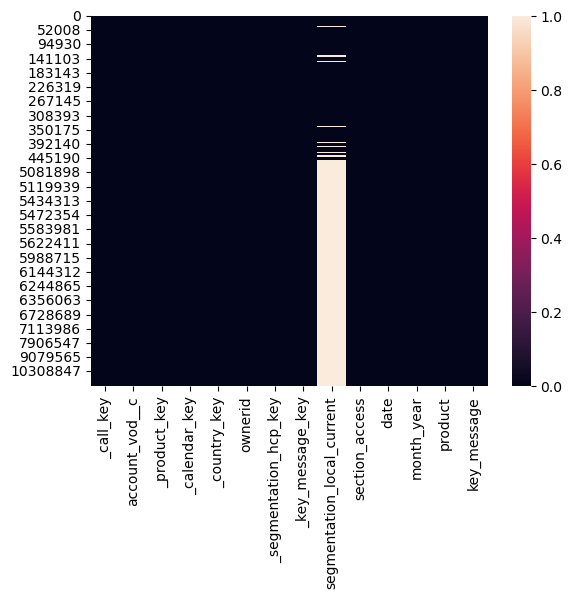

In [38]:
sns.heatmap(kmd_ci.isnull())

In [39]:
kmd_ci['product'].value_counts()

no_product    989061
Name: product, dtype: Int64

In [41]:
kmd_ci.drop(columns=['product'], inplace=True)

In [45]:
all(kmd_ci['_segmentation_hcp_key'] == kmd_ci['account_vod__c'])

True

In [46]:
kmd_ci.drop(columns=['_segmentation_hcp_key'], inplace=True)

In [74]:
kmd_ci['account_vod__c'].nunique()

63283

In [75]:
for g in kmd_ci.groupby('_country_key'):
    print('---------------------------------------')
    print('Country: ', g[0])
    print(g[1]['account_vod__c'].value_counts())
    print('Num HCPs: ', g[1]['account_vod__c'].nunique())

---------------------------------------
Country:  ALGERIA
0012o00002zzDs6AAE    65
0012o00002zzPMfAAM    59
0012o00002zz7GlAAI    58
0012o00002zzM5HAAU    57
0012o00002zzKR1AAM    56
                      ..
0012o00002zzLnXAAU     1
0012o00002zzDU4AAM     1
0012o00002zzDR6AAM     1
0012o00002zz74OAAQ     1
0012o00002zzD37AAE     1
Name: account_vod__c, Length: 1394, dtype: Int64
Num HCPs:  1394
---------------------------------------
Country:  BR
0010H00002n3RdcQAE    208
001f400000GQAN3AAP    175
001f400000GS1z0AAD    141
0010H00002n3RC4QAM    138
001f400000GR2JBAA1    132
                     ... 
001f400000GR0LbAAL      1
001f400000g5me6AAA      1
001f400000GRlpmAAD      1
001f400000GQdvVAAT      1
0010H00002n3SCYQA2      1
Name: account_vod__c, Length: 35094, dtype: Int64
Num HCPs:  35094
---------------------------------------
Country:  FRANCE
0012o00002XrgSWAAZ    276
0012o00002XpvgoAAB    230
0012o00002XpJLFAA3    194
0012o00002a4Qj9AAE    155
0012o00002Xq23kAAB    151
         

Let's examine some falls

In [55]:
kms = '; '.join(kmd_ci[kmd_ci['account_vod__c'] == '0012o00002Xh1LeAAJ']['key_message'])

In [56]:
kms

'REB Sicherheit; Selektivverträge; G_07_Therapy Management Cladribine; L_Scientific Exchange; Scientific Exchange Cladribine; L_Scientific Exchange; G_07_Therapy Management Cladribine; G_04_Communication of RWE-Data; G_02_Year 2; L_Competitor discussion CD20 mAbs; G_04_Communication of RWE-Data; L_Speaker Training; L_Impulse Therapy; L_Competitor discussion MOD; L_Long Term Therapy Strategies; L_Impulse Therapy; L_Long Term Therapy Strategies; G_09_Vaccination; L_Long Term Therapy Strategies; L_Impulse Therapy; L_Long Term Therapy Strategies; L_Scientific Exchange; G_02_Year 2; G_02_Year 2; G_07_Therapy Management Cladribine; L_Long Term Therapy Strategies; G_09_Vaccination; L_Speaker Training; L_Speaker Training; Scientific Exchange Cladribine; L_Mavenclad family planning; G_07_Therapy Management Cladribine; G_09_Vaccination; L_Scientific Exchange; G_04_Communication of RWE-Data; G_09_Vaccination; L_Impulse Therapy; G_02_Year 2; L_Long Term Therapy Strategies; L_Impulse Therapy; G_04_

In [57]:
import gensim
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string

In [61]:
data_words = [preprocess_string(remove_stopwords(t)) for t in kms.split()]

Let's take a closer look at the data

In [62]:
data_words = [d[0] for d in data_words if d]

In [65]:
vc = pd.Series(data_words).value_counts()

In [70]:
vc = vc[vc>1]

<AxesSubplot:>

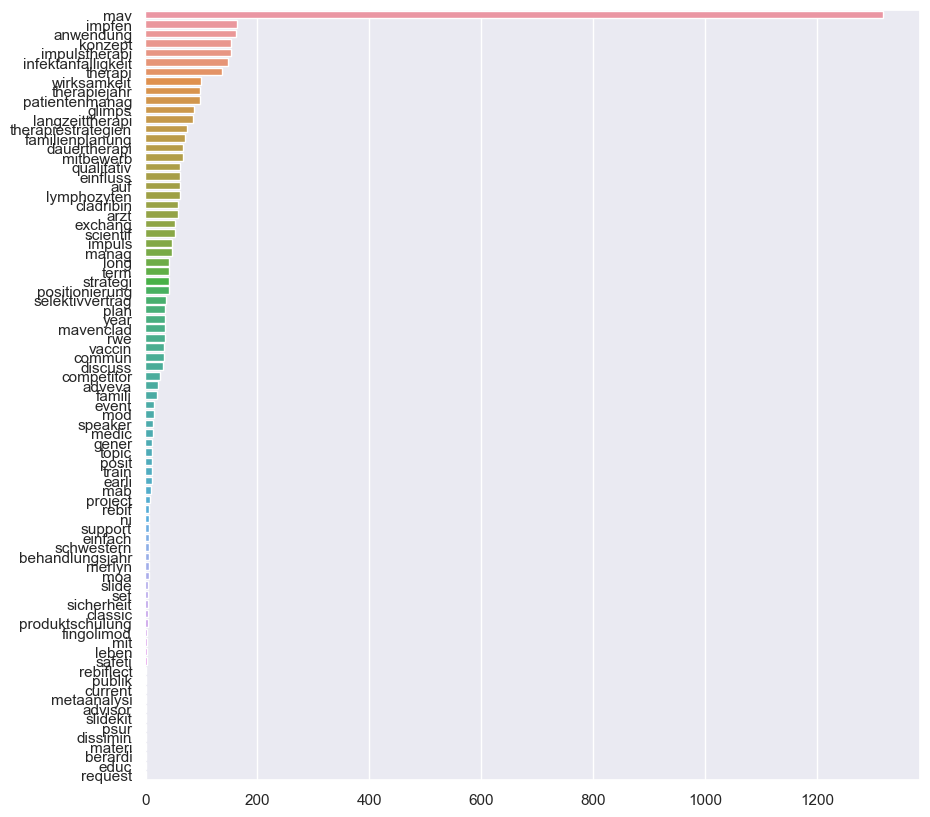

In [72]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.barplot(x=list(vc.values), y=list(vc.keys()))

Let's group the key messages together, save it and use in topic preprocessing

In [89]:
M = []
for g in kmd_ci.groupby('account_vod__c')['key_message']:
    messages = g[1].drop_duplicates()
    message = ';'.join(messages)
    M.append([g[0], message])



In [92]:
kmd_um = pd.DataFrame(M, columns=['account_vod__c', 'message'])

In [107]:
kmd = kmd_um.merge(kmd_ci.drop(columns='key_message'), on='account_vod__c', how='inner')

In [111]:
kmd.drop_duplicates(subset=['account_vod__c','message'], inplace=True)

In [112]:
kmd.to_csv('Sum_key_message_data.csv', index=False)

In [37]:
kmd = pd.read_csv('Sum_key_message_data.csv')

In [41]:
del kmd

#### Matching new data

In [43]:
del fd

In [52]:
full_dtypes = {'_account_key': 'string',
 'account': 'string',
 'account_city': 'string',
 'account_country': 'string',
 'account_country_code': 'string',
 'account_email': 'string',
 'account_inkl_onekey': 'string',
 'account_latitude': 'Float64',
 'account_longitude': 'Float64',
 'account_state': 'Int64',
 'account_status': 'string',
 'account_type': 'string',
 'account_id': 'string',
 'digital_affinity': 'string',
 'digital_segmentation': 'string',
 'gender': 'Int64',
 'hcp_franchise': 'string',
 'hcp_therapeutic_area': 'string',
 'ispersonaccount': 'boolean',
 'onekey_id': 'string',
 'specialty_1': 'string',
 'specialty_2': 'string',
 'veeva_id': 'string',
 'account_brick': 'object',
 'account_territories': 'string',
 'account_territories_per_bu': 'string',
 '_account_key_fdweb': 'string',
 'account_key_original': 'string',
 'account_id_na': 'boolean',
 '_webinar_key': 'Int64',
 '_calendar_key': 'Int64',
 '_product_key': 'Int64',
 '_segment_key': 'string',
 '_country_key': 'string',
 '_channel_key': 'string',
 '_campaign_key': 'object',
 'account_cnt': 'string',
 'webinar_participants_cnt': 'Int64',
 'event_allchannels_cnt': 'string',
 '_fact_allchannels_event': 'Int64',
 '_has_campaign_id': 'Int64',
 '_webinar_has_web_campaign': 'Int64',
 'webinar_cnt': 'Int64',
 '_timeline_key': 'string',
 'attendence_type': 'string',
 '_attended': 'Int64',
 '_fulltimeattended': 'Int64',
 'stream_time': 'Float64',
 'user_rating': 'string',
 'user_benefit_rate': 'Int64',
 'source_system': 'string',
 '_mslteam': 'Int64',
 '_datasource_f_webinars': 'Int64',
 'fact_source_': 'string',
 '_fact_actual': 'Int64',
 '_testaccount': 'Int64',
 '_individualcustomer': 'Int64',
 '_function_key': 'string',
 'fact_function': 'string',
 '_franchiseviewtimeline_key': 'string',
 '_remoteevent': 'Int64',
 '_f2fevent': 'Int64',
 'fact_country': 'string',
 'webinar_fileextension': 'string',
 'webinar_filename': 'string',
 'webinar_duration': 'Int64',
 'webinar_name': 'string',
 'webinar_platform': 'string',
 'account_id_fdweb': 'string',
 'date': 'string',
 'webinar_latitude': 'Float64',
 'webinar_longitude': 'Float64'}

In [53]:
full = pd.read_csv('data/fd_dacc_full.csv', dtype=full_dtypes)

In [49]:
kmd['account_vod__c'].nunique()

286050

In [47]:
M = []
for g in kmd.groupby('account_vod__c')['key_message']:
    messages = g[1].drop_duplicates()
    message = ';'.join(messages)
    M.append([g[0], message])

In [48]:
kmd_um = pd.DataFrame(M, columns=['account_vod__c', 'key_message'])

# kmd.drop_duplicates(subset=['account_vod__c','key_message'], inplace=True)

In [49]:
kmd_um.shape

(286050, 2)

In [51]:
kmd.drop_duplicates(subset='account_vod__c')['_country_key'].value_counts()

RUSSIA        54479
INDIA         35800
BR            35094
INDONESIA     17404
GERMANY       12713
              ...  
ESTONIA          57
NAF              54
NEAR EAST        42
SLOVENIA         41
MAURITANIA        6
Name: _country_key, Length: 73, dtype: Int64

In [54]:
kmd = full.merge(kmd_um, right_on='account_vod__c', left_on='veeva_id', how='left')

In [63]:
kmd = kmd[(kmd['account_vod__c'].notnull()) | (kmd['account_territories'].notnull())]

In [104]:
full.shape

(3201277, 72)

In [59]:
kmd['veeva_id'].nunique()

1162635

In [64]:
kmd[kmd['account_vod__c'].notnull()]['account_country'].value_counts()

Brazil          37196
Germany         12731
France          10793
Saudi Arabia     6174
Algeria          2868
Name: account_country, dtype: Int64

In [65]:
kmd.drop_duplicates(subset=['account_vod__c'])['account_country'].value_counts()

Brazil          35094
Germany         12692
France          10421
Saudi Arabia     3653
Algeria          1425
Name: account_country, dtype: Int64

In [66]:
kmd['account_country'].value_counts()

France          808067
Germany         272241
Algeria          46475
Brazil           37196
Saudi Arabia      8215
Name: account_country, dtype: Int64

In [58]:
kmd['account_vod__c'].nunique()

63284

In [89]:
kmd.head()

,_account_key,account,account_city,account_country,account_country_code,account_email,account_inkl_onekey,account_latitude,account_longitude,account_state,account_status,account_type,account_id,digital_affinity,digital_segmentation,gender,hcp_franchise,hcp_therapeutic_area,ispersonaccount,onekey_id,specialty_1,specialty_2,veeva_id,account_brick,account_territories,account_territories_per_bu,_account_key_fdweb,account_key_original,account_id_na,_webinar_key,_calendar_key,_product_key,_segment_key,_country_key,_channel_key,_campaign_key,account_cnt,webinar_participants_cnt,event_allchannels_cnt,_fact_allchannels_event,_has_campaign_id,_webinar_has_web_campaign,webinar_cnt,_timeline_key,attendence_type,_attended,_fulltimeattended,stream_time,user_rating,user_benefit_rate,source_system,_mslteam,_datasource_f_webinars,fact_source_,_fact_actual,_testaccount,_individualcustomer,_function_key,fact_function,_franchiseviewtimeline_key,_remoteevent,_f2fevent,fact_country,webinar_fileextension,webinar_filename,webinar_duration,webinar_name,webinar_platform,account_id_fdweb,date,webinar_latitude,webinar_longitude,account_vod__c,key_message
2,LATAM_Veeva|001f400000GRi8KAAT,MARCELO ANDRE DE FERRAZ BARROS,SERRA TALHADA-PE,Brazil,BR,<NA>,MARCELO ANDRE DE FERRAZ BARROS - WBR...,<NA>,<NA>,<NA>,<NA>,<NA>,001f400000GRi8KAAT,<NA>,<NA>,<NA>,CM&E,<NA>,True,WBRM00108079,Geriatrics,General Medicine,001f400000GRi8KAAT,0880,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,001f400000GRi8KAAT,Eficácia: Atuação aproximadamente 20...
70,LATAM_Veeva|001f400000GRdxVAAT,EDUARDO BARRETO GADELHA,RECIFE-PE,Brazil,BR,<NA>,EDUARDO BARRETO GADELHA - WBRM00080763,<NA>,<NA>,<NA>,<NA>,<NA>,001f400000GRdxVAAT,<NA>,<NA>,<NA>,CM&E,<NA>,True,WBRM00080763,Cardiology,<NA>,001f400000GRdxVAAT,0844,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,001f400000GRdxVAAT,Mais potente na redução do LDL e n-H...
363,LATAM_Veeva|001f400000GRb9BAAT,SILVIA DA SILVA FERREIRA,SAO VICENTE-SP,Brazil,BR,<NA>,SILVIA DA SILVA FERREIRA - WBRM00053613,<NA>,<NA>,<NA>,<NA>,<NA>,001f400000GRb9BAAT,<NA>,<NA>,<NA>,CM&E,<NA>,True,WBRM00053613,General Medicine,<NA>,001f400000GRb9BAAT,0174,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,001f400000GRb9BAAT,Preço competitivo
367,LATAM_Veeva|001f400000GRbA5AAL,MARCELA LAGOAS NETO,BELO HORIZONTE-MG,Brazil,BR,<NA>,MARCELA LAGOAS NETO - WBRM00053715,<NA>,<NA>,<NA>,<NA>,<NA>,001f400000GRbA5AAL,<NA>,<NA>,<NA>,Oncology,<NA>,True,WBRM00053715,Oncology,<NA>,001f400000GRbA5AAL,0514,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,001f400000GRbA5AAL,Consistência de dados em estudos fas...
872,LATAM_Veeva|001f400000t3XkdAAE,MANOELLA MACEDO E SILVA,CURITIBA-PR,Brazil,BR,<NA>,MANOELLA MACEDO E SILVA - WBRM00557079,<NA>,<NA>,<NA>,<NA>,<NA>,001f400000t3XkdAAE,<NA>,<NA>,<NA>,CM&E,<NA>,True,WBRM00557079,Cardiology,General Medicine,001f400000t3XkdAAE,1163,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,001f400000t3XkdAAE,Preço competitivo


In [53]:
kmd['account_vod__c'].count()

69762

In [69]:
kmd['account_territories'].count()

1133472

In [90]:
matched_kmd = kmd[kmd['_webinar_key'].notnull()]

In [91]:
matched_kmd.shape

(13859, 74)

In [94]:
# are we intrested in those people?
matched_kmd[(matched_kmd['account_vod__c'].notnull()) | (matched_kmd['account_territories'].notnull())]['_account_key'].nunique()

4960

In [97]:
kmd.drop(columns='account_vod__c', inplace=True)

In [98]:
kmd.to_csv('fd_dacc_km_28-11-2022.csv', index=False)

In [14]:
kmd = pd.read_csv('fd_dacc_km_28-11-2022.csv')

C:\Users\M302242\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3433: DtypeWarning: Columns (5,11,13,17,26,27,28,32,33,34,35,36,38,43,44,48,50,53,57,58,59,62,63,64,66,67,68,69) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
matched_kmd = kmd[kmd['_webinar_key'].notnull()]

In [20]:
kmd[kmd['account_territories'].notnull()].shape

(1133472, 73)

In [21]:
kmd[kmd['key_message'].notnull()].shape

(69762, 73)

In [16]:
matched_kmd[matched_kmd['account_territories'].notnull()].shape

(10457, 73)

In [29]:
matched_kmd[matched_kmd['account_territories'].notnull()]['_account_key'].nunique()

3737

In [18]:
matched_kmd[matched_kmd['key_message'].notnull()].shape

(9441, 73)

In [26]:
matched_kmd[matched_kmd['key_message'].notnull()]['_account_key'].nunique()

3439

In [25]:
kmd[kmd['key_message'].notnull()]['_account_key'].nunique()

63284

In [24]:
kmd[kmd['account_territories'].notnull()]['_account_key'].nunique()

1126211

In [62]:
# lets look at the disjunktions of account_terriotires and key_messages
terr_dj = matched_kmd[matched_kmd['account_territories'].notnull()]['account_vod__c']
mess_dj = matched_kmd[matched_kmd['account_vod__c'].notnull()]['account_territories']

In [65]:
terr_dj.nunique()

2216

In [66]:
mess_dj.nunique()

642

#### Sum-up:

Key messages:
- 69.762 key messages for the full dataset of 3.169.545 HCPs.
- 9.441 key messages for the matched set of 31.597 HCPs .

Account_territories(ATs)
- 1.133.472 ATs for the full dataset
- 10.457 ATs for the matched set

Since we only have 2.216 unique key messages inside of the set of ATs and 642 unique ATs inside of the set of key messages, the sets aren't subsets of any kind. Even overlapping is difficult. So we can may be use it, to identify, which HCPs we have interest in, but nothing fancy.

In [27]:
3169545 - 69762

3099783